In [1]:
import sys

import numpy as np
import pickle
import os
import pandas as pd

import time

import scanpy
import numpy as np

import torch
from torch import optim


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import anndata as ad

import model_lord



/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
skin_rnaPath='/data/xinyi/shareseq/skin_rna.h5ad'
skin_rna=scanpy.read(skin_rnaPath)


In [4]:
skin_atacPath='/data/xinyi/shareseq/skin_atac.h5ad'
skin_atac=scanpy.read(skin_atacPath)


In [6]:
print(skin_rna.shape)
print(skin_atac.shape)

(34774, 22666)
(34774, 70284)


In [7]:
scanpy.settings.verbosity = 3 

In [8]:

scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)

filtered out 13321 genes that are detected in less than 300 cells
filtered out 10524 genes that are detected in less than 300 cells


In [9]:
scanpy.pp.filter_cells(skin_atac, min_genes=300)

In [10]:
scanpy.pp.filter_cells(skin_rna, min_genes=300)

filtered out 6635 cells that have less than 300 genes expressed


In [11]:
skin_atac=skin_atac[skin_rna.obs.index]

In [12]:
print(skin_rna.shape)
print(skin_atac.shape)

(28139, 9345)
(28139, 59760)


In [13]:

scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)

filtered out 192 genes that are detected in less than 300 cells
filtered out 1590 genes that are detected in less than 300 cells


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [14]:
scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]

filtered out 41 cells that have less than 300 genes expressed


In [15]:
print(skin_rna.shape)
print(skin_atac.shape)

(28098, 9153)
(28098, 58170)


In [16]:
atac=skin_atac.X.toarray()
rna=skin_rna.X.toarray()

In [17]:
atac_posweight=(atac.size-np.sum(atac))/np.sum(atac)
rna_posweight=(rna.size-np.sum(rna))/np.sum(rna)

In [18]:
rna.shape

(28098, 9153)

In [19]:
atac.shape

(28098, 58170)

In [5]:
log_data=True
normalize='minmax'
hiddenSize=1024
sharedSize=50
dSpecificSize=20

In [21]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(atac.shape[0])
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*atac.shape[0])]
testIdx_all=allIdx_all[int(pctVal*atac.shape[0]):(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0]))]
trainIdx_all=allIdx_all[(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0])):]



In [23]:
#preprocess
if log_data:
    rna=np.log(rna+1/2)
    atac=np.log(atac+1/2)
if normalize=='zscore':
    scaler_rna = StandardScaler()
    scaler_rna.fit(rna[trainIdx_all])
    rna=scaler_rna.transform(rna)
    
    scaler_atac = StandardScaler()
    scaler_atac.fit(atac[trainIdx_all])
    atac=scaler_atac.transform(atac)
elif normalize=='minmax':
    rna=(rna-np.min(rna,axis=1,keepdims=True))/(np.max(rna,axis=1,keepdims=True)-np.min(rna,axis=1,keepdims=True))
    atac=(atac-np.min(atac,axis=1,keepdims=True))/(np.max(atac,axis=1,keepdims=True)-np.min(atac,axis=1,keepdims=True))

In [25]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

batchsize=512
saveFreq=100
epochs=5000
lr_latent=0.001
lr_decoder=0.0001
weight_decay=0
seed=3

dropout=0.01
XreconWeight=20
ridgeL=0.01

addNoise=True
actDecay=0.001

testSaveName='shareseq_lord'
name='randNoise_sharedRecon_bceWweight_bce_morefilter'
logsavepath=os.path.join('/data/xinyi/shareseq/results/log',testSaveName,name)
modelsavepath=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)
plotsavepath=os.path.join('/data/xinyi/shareseq/results/plots',testSaveName,name)

loss_x_rna=torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(rna_posweight).cuda())
loss_x_atac=torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(atac_posweight).cuda())

In [26]:
if not os.path.exists(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName)):
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/models',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/log',testSaveName))
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)
nFeatures_rna=rna.shape[1]
nFeatures_atac=atac.shape[1]

In [27]:
train_nodes_idx=trainIdx_all
val_nodes_idx=valIdx_all

In [28]:
def train(epoch):
    t = time.time()
    model_rna.train()
    model_atac.train()
    model_rna_shared.train()
    model_atac_shared.train()
    
    loss_all=0
    loss_x_train_all_rna=0
    loss_x_train_all_atac=0
    loss_xShared_train_all_rna=0
    loss_xShared_train_all_atac=0
    loss_lNorm_all=0
    loss_lNorm_all_rna=0
    loss_lNorm_all_atac=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        traintarget_rna=torch.tensor(rna[trainIdx]).cuda().float()
        traintarget_atac=torch.tensor(atac[trainIdx]).cuda().float()
        trainIdx=torch.tensor(trainIdx)
        trainInput_shared=latent_shared(trainIdx).cuda().float()
        trainInput_rna=latent_rna(trainIdx).cuda().float()
        trainInput_atac=latent_atac(trainIdx).cuda().float()

        if addNoise:
            trainInput_shared=trainInput_shared+torch.randn_like(trainInput_shared)
            trainInput_rna=trainInput_rna+torch.randn_like(trainInput_rna)
            trainInput_atac=trainInput_atac+torch.randn_like(trainInput_atac)
            
        optimizer_rna.zero_grad()
        optimizer_rna_shared.zero_grad()
        optimizer_latent.zero_grad()
        optimizer_atac.zero_grad()
        optimizer_atac_shared.zero_grad()

        recon_rna= model_rna(torch.cat((trainInput_shared,trainInput_rna),dim=1))
        atac_recon = model_atac(torch.cat((trainInput_shared,trainInput_atac),dim=1))
        recon_rna_shared= model_rna_shared(trainInput_shared)
        atac_recon_shared = model_atac_shared(trainInput_shared)

        loss_x_train_rna=loss_x_rna(recon_rna, traintarget_rna)
        loss_x_train_atac=loss_x_atac(atac_recon, traintarget_atac)        
        loss_xShared_train_rna=loss_x_rna(recon_rna_shared, traintarget_rna)
        loss_xShared_train_atac=loss_x_atac(atac_recon_shared, traintarget_atac)        
        loss=loss_x_train_rna+loss_x_train_atac+loss_xShared_train_rna+loss_xShared_train_atac
        
        if addNoise:
            loss_lNorm=torch.mean(torch.linalg.norm(latent_shared(trainIdx).cuda(),dim=1))/latent_shared.embedding_dim
            loss_lNorm_all+=loss_lNorm.item()
            loss+=loss_lNorm*actDecay
            
            loss_lNorm_rna=torch.mean(torch.linalg.norm(latent_rna(trainIdx).cuda(),dim=1))/latent_rna.embedding_dim
            loss_lNorm_all_rna+=loss_lNorm_rna.item()
            loss+=loss_lNorm_rna*actDecay
            
            loss_lNorm_atac=torch.mean(torch.linalg.norm(latent_atac(trainIdx).cuda(),dim=1))/latent_atac.embedding_dim
            loss_lNorm_all_atac+=loss_lNorm_atac.item()
            loss+=loss_lNorm_atac*actDecay
            
        
        loss_x_train_all_atac+=loss_x_train_atac.item()
        loss_x_train_all_rna+=loss_x_train_rna.item()
        loss_xShared_train_all_atac+=loss_xShared_train_atac.item()
        loss_xShared_train_all_rna+=loss_xShared_train_rna.item()
        loss_all+=loss.item()
        
            
        loss.backward()
        optimizer_rna.step()
        optimizer_latent.step()
        optimizer_atac.step()
        optimizer_rna_shared.step()
        optimizer_atac_shared.step()


    loss_x_train_all_atac=loss_x_train_all_atac/ntrainBatches
    loss_x_train_all_rna=loss_x_train_all_rna/ntrainBatches
    loss_xShared_train_all_atac=loss_xShared_train_all_atac/ntrainBatches
    loss_xShared_train_all_rna=loss_xShared_train_all_rna/ntrainBatches
    loss_all=loss_all/ntrainBatches
    if addNoise:
        loss_lNorm_all=loss_lNorm_all/ntrainBatches
        loss_lNorm_all_rna=loss_lNorm_all_rna/ntrainBatches
        loss_lNorm_all_atac=loss_lNorm_all_atac/ntrainBatches

    
    with torch.no_grad():
        model_rna.eval()
        model_atac.eval()
        model_rna_shared.eval()
        model_atac_shared.eval()
        loss_x_val_all_rna=0
        loss_x_val_all_atac=0
        loss_xShared_val_all_rna=0
        loss_xShared_val_all_atac=0
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            valtarget_rna=torch.tensor(rna[valIdx]).cuda().float()
            valtarget_atac=torch.tensor(atac[valIdx]).cuda().float()
            valIdx=torch.tensor(valIdx)
            valInput_shared=latent_shared(valIdx).cuda().float()
            valInput_rna=latent_rna(valIdx).cuda().float()
            valInput_atac=latent_atac(valIdx).cuda().float()

            recon_rna= model_rna(torch.cat((valInput_shared,valInput_rna),dim=1))
            atac_recon = model_atac(torch.cat((valInput_shared,valInput_atac),dim=1))
            recon_rna_shared= model_rna_shared(valInput_shared)
            atac_recon_shared = model_atac_shared(valInput_shared)



            loss_x_val_rna=loss_x_rna(recon_rna, valtarget_rna)
            loss_x_val_atac=loss_x_atac(atac_recon, valtarget_atac)
            loss_xShared_val_rna=loss_x_rna(recon_rna_shared, valtarget_rna)
            loss_xShared_val_atac=loss_x_atac(atac_recon_shared, valtarget_atac)


            loss=loss_x_val_rna+loss_x_val_atac+loss_xShared_val_rna+loss_xShared_val_atac
            
            loss_x_val_all_rna+=loss_x_val_rna.item()
            loss_x_val_all_atac+=loss_x_val_atac.item()
            loss_xShared_val_all_rna+=loss_xShared_val_rna.item()
            loss_xShared_val_all_atac+=loss_xShared_val_atac.item()
            loss_val_all+=loss.item()

        loss_x_val_all_rna=loss_x_val_all_rna/nvalBatches
        loss_x_val_all_atac=loss_x_val_all_atac/nvalBatches
        loss_xShared_val_all_rna=loss_xShared_val_all_rna/nvalBatches
        loss_xShared_val_all_atac=loss_xShared_val_all_atac/nvalBatches
        loss_val_all=loss_val_all/nvalBatches
    
    print(' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_x_train_rna: {:.4f}'.format(loss_x_train_all_rna),
          'loss_x_train_atac: {:.4f}'.format(loss_x_train_all_atac),
          'loss_xShared_train_rna: {:.4f}'.format(loss_xShared_train_all_rna),
          'loss_xShared_train_atac: {:.4f}'.format(loss_xShared_train_all_atac),
          'loss_val: {:.4f}'.format(loss_val_all),
          'loss_x_val_rna: {:.4f}'.format(loss_x_val_all_rna),
          'loss_x_val_atac: {:.4f}'.format(loss_x_val_all_atac),
          'loss_xShared_val_rna: {:.4f}'.format(loss_xShared_val_all_rna),
          'loss_xShared_val_atac: {:.4f}'.format(loss_xShared_val_all_atac),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_x_train_all_rna,loss_x_train_all_atac,loss_xShared_train_all_rna,loss_xShared_train_all_atac,loss_val_all,loss_x_val_all_rna,loss_x_val_all_atac,loss_xShared_val_all_rna,loss_xShared_val_all_atac,loss_lNorm_all,loss_lNorm_all_rna,loss_lNorm_all_atac




In [29]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True

model_rna = model_lord.fc_decode_l4(nFeatures_rna,sharedSize+dSpecificSize,hiddenSize, dropout)
model_atac = model_lord.fc_decode_l4(nFeatures_atac, sharedSize+dSpecificSize,hiddenSize, dropout)

model_rna_shared = model_lord.fc_decode_l4(nFeatures_rna,sharedSize,hiddenSize, dropout)
model_atac_shared = model_lord.fc_decode_l4(nFeatures_atac, sharedSize,hiddenSize, dropout)

model_rna.cuda()
model_atac.cuda()
model_rna_shared.cuda()
model_atac_shared.cuda()

optimizer_rna = optim.Adam(model_rna.parameters(), lr=lr_decoder, weight_decay=weight_decay)
optimizer_atac = optim.Adam(model_atac.parameters(), lr=lr_decoder, weight_decay=weight_decay)

optimizer_rna_shared = optim.Adam(model_rna_shared.parameters(), lr=lr_decoder, weight_decay=weight_decay)
optimizer_atac_shared = optim.Adam(model_atac_shared.parameters(), lr=lr_decoder, weight_decay=weight_decay)

latent_shared=torch.nn.Embedding(rna.shape[0],sharedSize)
latent_rna=torch.nn.Embedding(rna.shape[0],dSpecificSize)
latent_atac=torch.nn.Embedding(rna.shape[0],dSpecificSize)
optimizer_latent= torch.optim.Adam([latent_shared.weight,latent_rna.weight,latent_atac.weight], lr=lr_latent, weight_decay=weight_decay)

train_loss=[np.inf]*(epochs)
val_loss=[np.inf]*(epochs)

train_loss_rna=[np.inf]*(epochs)
val_loss_rna=[np.inf]*(epochs)
train_loss_rna_shared=[np.inf]*(epochs)
val_loss_rna_shared=[np.inf]*(epochs)

train_loss_atac=[np.inf]*(epochs)
train_loss_atac_shared=[np.inf]*(epochs)
val_loss_atac=[np.inf]*(epochs)
val_loss_atac_shared=[np.inf]*(epochs)

train_lNorm=[np.inf]*(epochs)
train_lNorm_rna=[np.inf]*(epochs)
train_lNorm_atac=[np.inf]*(epochs)

t_ep=time.time()

for ep in range(epochs):

    train_loss[ep],train_loss_rna[ep],train_loss_atac[ep],train_loss_rna_shared[ep],train_loss_atac_shared[ep],val_loss[ep],val_loss_rna[ep],val_loss_atac[ep],val_loss_rna_shared[ep],val_loss_atac_shared[ep],train_lNorm[ep],train_lNorm_rna[ep],train_lNorm_atac[ep]=train(ep)


    if ep%saveFreq == 0 and ep != 0:
        torch.save(model_rna.cpu().state_dict(), os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(ep)+'_rna.pt'))
        torch.save(model_atac.cpu().state_dict(), os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(ep)+'_atac.pt'))
        torch.save(model_rna_shared.cpu().state_dict(), os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(ep)+'_rnaShared.pt'))
        torch.save(model_atac_shared.cpu().state_dict(), os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(ep)+'_atacShared.pt'))


        with open(os.path.join(modelsavepath,'latentRNA_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(ep)), 'wb') as output:
            pickle.dump(latent_rna.weight, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(modelsavepath,'latentShared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(ep)), 'wb') as output:
            pickle.dump(latent_shared.weight, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(modelsavepath,'latentATAC_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(ep)), 'wb') as output:
            pickle.dump(latent_atac.weight, output, pickle.HIGHEST_PROTOCOL)



    model_rna.cuda()
    model_atac.cuda()
    model_rna_shared.cuda()
    model_atac_shared.cuda()
    torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


with open(os.path.join(logsavepath,'train_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_rna_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(train_loss_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_rna_shared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(train_loss_rna_shared, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_rna_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(val_loss_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_rna_shared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(val_loss_rna_shared, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_atac_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(train_loss_atac, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_atac_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(val_loss_atac, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_atac_shared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(train_loss_atac_shared, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_atac_shared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(val_loss_atac_shared, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_lNorm_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(train_lNorm, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_lNormRNA_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(train_lNorm_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_lNormATAC_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'wb') as output:
    pickle.dump(train_lNorm_atac, output, pickle.HIGHEST_PROTOCOL)



plt.plot(np.arange(epochs),train_loss_rna)
plt.plot(np.arange(epochs),val_loss_rna)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_rna'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'.jpg'))
plt.show()



plt.plot(np.arange(epochs),train_loss_atac)
plt.plot(np.arange(epochs),val_loss_atac)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_atac'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'.jpg'))
plt.show()


plt.plot(np.arange(epochs),train_lNorm)
plt.plot(np.arange(epochs),train_lNorm_rna)
plt.plot(np.arange(epochs),train_lNorm_atac)
plt.legend(['shared l2','rna l2','atac l2'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_lNorm'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'.jpg'))
plt.show()



 Epoch: 0000 loss_train: 2.8082 loss_x_train_rna: 0.5022 loss_x_train_atac: 0.9020 loss_xShared_train_rna: 0.5016 loss_xShared_train_atac: 0.9018 loss_val: 2.4244 loss_x_val_rna: 0.3667 loss_x_val_atac: 0.8504 loss_xShared_val_rna: 0.3582 loss_xShared_val_atac: 0.8491 time: 10.2229s
 Epoch: 0001 loss_train: 2.3173 loss_x_train_rna: 0.3115 loss_x_train_atac: 0.8473 loss_xShared_train_rna: 0.3112 loss_xShared_train_atac: 0.8468 loss_val: 2.2662 loss_x_val_rna: 0.2904 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2908 loss_xShared_val_atac: 0.8423 time: 9.5052s
 Epoch: 0002 loss_train: 2.2557 loss_x_train_rna: 0.2841 loss_x_train_atac: 0.8439 loss_xShared_train_rna: 0.2839 loss_xShared_train_atac: 0.8433 loss_val: 2.2412 loss_x_val_rna: 0.2790 loss_x_val_atac: 0.8418 loss_xShared_val_rna: 0.2793 loss_xShared_val_atac: 0.8411 time: 9.4989s
 Epoch: 0003 loss_train: 2.2383 loss_x_train_rna: 0.2774 loss_x_train_atac: 0.8419 loss_xShared_train_rna: 0.2772 loss_xShared_train_atac: 0.8412 loss

 Epoch: 0029 loss_train: 2.1703 loss_x_train_rna: 0.2682 loss_x_train_atac: 0.8145 loss_xShared_train_rna: 0.2688 loss_xShared_train_atac: 0.8182 loss_val: 2.2349 loss_x_val_rna: 0.2727 loss_x_val_atac: 0.8458 loss_xShared_val_rna: 0.2727 loss_xShared_val_atac: 0.8437 time: 9.0231s
 Epoch: 0030 loss_train: 2.1680 loss_x_train_rna: 0.2680 loss_x_train_atac: 0.8136 loss_xShared_train_rna: 0.2686 loss_xShared_train_atac: 0.8173 loss_val: 2.2357 loss_x_val_rna: 0.2729 loss_x_val_atac: 0.8463 loss_xShared_val_rna: 0.2729 loss_xShared_val_atac: 0.8436 time: 8.8727s
 Epoch: 0031 loss_train: 2.1659 loss_x_train_rna: 0.2678 loss_x_train_atac: 0.8127 loss_xShared_train_rna: 0.2685 loss_xShared_train_atac: 0.8164 loss_val: 2.2375 loss_x_val_rna: 0.2730 loss_x_val_atac: 0.8470 loss_xShared_val_rna: 0.2728 loss_xShared_val_atac: 0.8448 time: 9.0374s
 Epoch: 0032 loss_train: 2.1643 loss_x_train_rna: 0.2675 loss_x_train_atac: 0.8120 loss_xShared_train_rna: 0.2683 loss_xShared_train_atac: 0.8159 loss_

 Epoch: 0058 loss_train: 2.1286 loss_x_train_rna: 0.2637 loss_x_train_atac: 0.7969 loss_xShared_train_rna: 0.2654 loss_xShared_train_atac: 0.8021 loss_val: 2.2490 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8512 loss_xShared_val_rna: 0.2737 loss_xShared_val_atac: 0.8498 time: 9.9062s
 Epoch: 0059 loss_train: 2.1271 loss_x_train_rna: 0.2636 loss_x_train_atac: 0.7965 loss_xShared_train_rna: 0.2652 loss_xShared_train_atac: 0.8012 loss_val: 2.2487 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8509 loss_xShared_val_rna: 0.2739 loss_xShared_val_atac: 0.8496 time: 9.8103s
 Epoch: 0060 loss_train: 2.1257 loss_x_train_rna: 0.2634 loss_x_train_atac: 0.7958 loss_xShared_train_rna: 0.2651 loss_xShared_train_atac: 0.8008 loss_val: 2.2492 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8513 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8496 time: 10.1552s
 Epoch: 0061 loss_train: 2.1251 loss_x_train_rna: 0.2633 loss_x_train_atac: 0.7955 loss_xShared_train_rna: 0.2650 loss_xShared_train_atac: 0.8006 loss

 Epoch: 0087 loss_train: 2.1011 loss_x_train_rna: 0.2607 loss_x_train_atac: 0.7858 loss_xShared_train_rna: 0.2627 loss_xShared_train_atac: 0.7913 loss_val: 2.2536 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8526 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8518 time: 9.6660s
 Epoch: 0088 loss_train: 2.1008 loss_x_train_rna: 0.2607 loss_x_train_atac: 0.7856 loss_xShared_train_rna: 0.2628 loss_xShared_train_atac: 0.7911 loss_val: 2.2542 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8525 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8522 time: 9.9158s
 Epoch: 0089 loss_train: 2.0998 loss_x_train_rna: 0.2605 loss_x_train_atac: 0.7853 loss_xShared_train_rna: 0.2627 loss_xShared_train_atac: 0.7908 loss_val: 2.2543 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8523 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8526 time: 9.6762s
 Epoch: 0090 loss_train: 2.0990 loss_x_train_rna: 0.2604 loss_x_train_atac: 0.7848 loss_xShared_train_rna: 0.2627 loss_xShared_train_atac: 0.7904 loss_

 Epoch: 0116 loss_train: 2.0772 loss_x_train_rna: 0.2583 loss_x_train_atac: 0.7758 loss_xShared_train_rna: 0.2607 loss_xShared_train_atac: 0.7818 loss_val: 2.2557 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8532 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8526 time: 9.5804s
 Epoch: 0117 loss_train: 2.0763 loss_x_train_rna: 0.2582 loss_x_train_atac: 0.7753 loss_xShared_train_rna: 0.2606 loss_xShared_train_atac: 0.7815 loss_val: 2.2569 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8542 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8534 time: 9.7591s
 Epoch: 0118 loss_train: 2.0756 loss_x_train_rna: 0.2582 loss_x_train_atac: 0.7751 loss_xShared_train_rna: 0.2605 loss_xShared_train_atac: 0.7812 loss_val: 2.2566 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8538 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8532 time: 9.6138s
 Epoch: 0119 loss_train: 2.0750 loss_x_train_rna: 0.2580 loss_x_train_atac: 0.7750 loss_xShared_train_rna: 0.2604 loss_xShared_train_atac: 0.7810 loss_

 Epoch: 0145 loss_train: 2.0542 loss_x_train_rna: 0.2561 loss_x_train_atac: 0.7661 loss_xShared_train_rna: 0.2586 loss_xShared_train_atac: 0.7727 loss_val: 2.2580 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8542 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8542 time: 9.7075s
 Epoch: 0146 loss_train: 2.0533 loss_x_train_rna: 0.2561 loss_x_train_atac: 0.7657 loss_xShared_train_rna: 0.2585 loss_xShared_train_atac: 0.7723 loss_val: 2.2594 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8550 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8548 time: 9.8399s
 Epoch: 0147 loss_train: 2.0524 loss_x_train_rna: 0.2560 loss_x_train_atac: 0.7653 loss_xShared_train_rna: 0.2585 loss_xShared_train_atac: 0.7719 loss_val: 2.2599 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8553 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8549 time: 10.1068s
 Epoch: 0148 loss_train: 2.0516 loss_x_train_rna: 0.2559 loss_x_train_atac: 0.7651 loss_xShared_train_rna: 0.2584 loss_xShared_train_atac: 0.7715 loss

 Epoch: 0174 loss_train: 2.0318 loss_x_train_rna: 0.2542 loss_x_train_atac: 0.7564 loss_xShared_train_rna: 0.2568 loss_xShared_train_atac: 0.7637 loss_val: 2.2630 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8568 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8559 time: 9.7095s
 Epoch: 0175 loss_train: 2.0305 loss_x_train_rna: 0.2541 loss_x_train_atac: 0.7560 loss_xShared_train_rna: 0.2567 loss_xShared_train_atac: 0.7632 loss_val: 2.2629 loss_x_val_rna: 0.2753 loss_x_val_atac: 0.8568 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8560 time: 10.3468s
 Epoch: 0176 loss_train: 2.0301 loss_x_train_rna: 0.2540 loss_x_train_atac: 0.7557 loss_xShared_train_rna: 0.2566 loss_xShared_train_atac: 0.7630 loss_val: 2.2624 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8562 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8561 time: 9.5989s
 Epoch: 0177 loss_train: 2.0291 loss_x_train_rna: 0.2540 loss_x_train_atac: 0.7553 loss_xShared_train_rna: 0.2566 loss_xShared_train_atac: 0.7625 loss

 Epoch: 0203 loss_train: 2.0090 loss_x_train_rna: 0.2522 loss_x_train_atac: 0.7466 loss_xShared_train_rna: 0.2549 loss_xShared_train_atac: 0.7546 loss_val: 2.2639 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8569 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8567 time: 9.5961s
 Epoch: 0204 loss_train: 2.0084 loss_x_train_rna: 0.2522 loss_x_train_atac: 0.7463 loss_xShared_train_rna: 0.2550 loss_xShared_train_atac: 0.7542 loss_val: 2.2639 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8570 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8565 time: 10.1369s
 Epoch: 0205 loss_train: 2.0078 loss_x_train_rna: 0.2522 loss_x_train_atac: 0.7460 loss_xShared_train_rna: 0.2549 loss_xShared_train_atac: 0.7539 loss_val: 2.2633 loss_x_val_rna: 0.2753 loss_x_val_atac: 0.8571 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8562 time: 9.8734s
 Epoch: 0206 loss_train: 2.0068 loss_x_train_rna: 0.2521 loss_x_train_atac: 0.7456 loss_xShared_train_rna: 0.2548 loss_xShared_train_atac: 0.7536 loss

 Epoch: 0232 loss_train: 1.9874 loss_x_train_rna: 0.2505 loss_x_train_atac: 0.7372 loss_xShared_train_rna: 0.2533 loss_xShared_train_atac: 0.7457 loss_val: 2.2660 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8574 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8577 time: 9.7107s
 Epoch: 0233 loss_train: 1.9867 loss_x_train_rna: 0.2504 loss_x_train_atac: 0.7369 loss_xShared_train_rna: 0.2532 loss_xShared_train_atac: 0.7454 loss_val: 2.2647 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8569 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8573 time: 9.6500s
 Epoch: 0234 loss_train: 1.9858 loss_x_train_rna: 0.2503 loss_x_train_atac: 0.7365 loss_xShared_train_rna: 0.2532 loss_xShared_train_atac: 0.7451 loss_val: 2.2663 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8580 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8575 time: 9.7535s
 Epoch: 0235 loss_train: 1.9850 loss_x_train_rna: 0.2503 loss_x_train_atac: 0.7362 loss_xShared_train_rna: 0.2530 loss_xShared_train_atac: 0.7447 loss_

 Epoch: 0261 loss_train: 1.9664 loss_x_train_rna: 0.2487 loss_x_train_atac: 0.7281 loss_xShared_train_rna: 0.2516 loss_xShared_train_atac: 0.7371 loss_val: 2.2652 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8570 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8572 time: 9.6805s
 Epoch: 0262 loss_train: 1.9655 loss_x_train_rna: 0.2487 loss_x_train_atac: 0.7277 loss_xShared_train_rna: 0.2515 loss_xShared_train_atac: 0.7367 loss_val: 2.2660 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8575 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8576 time: 9.6659s
 Epoch: 0263 loss_train: 1.9650 loss_x_train_rna: 0.2487 loss_x_train_atac: 0.7275 loss_xShared_train_rna: 0.2515 loss_xShared_train_atac: 0.7366 loss_val: 2.2650 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8570 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8570 time: 9.7920s
 Epoch: 0264 loss_train: 1.9640 loss_x_train_rna: 0.2485 loss_x_train_atac: 0.7270 loss_xShared_train_rna: 0.2514 loss_xShared_train_atac: 0.7362 loss_

 Epoch: 0290 loss_train: 1.9464 loss_x_train_rna: 0.2471 loss_x_train_atac: 0.7194 loss_xShared_train_rna: 0.2500 loss_xShared_train_atac: 0.7290 loss_val: 2.2648 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8565 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8570 time: 10.0403s
 Epoch: 0291 loss_train: 1.9455 loss_x_train_rna: 0.2470 loss_x_train_atac: 0.7190 loss_xShared_train_rna: 0.2499 loss_xShared_train_atac: 0.7287 loss_val: 2.2652 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8568 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8572 time: 9.7715s
 Epoch: 0292 loss_train: 1.9451 loss_x_train_rna: 0.2470 loss_x_train_atac: 0.7189 loss_xShared_train_rna: 0.2499 loss_xShared_train_atac: 0.7285 loss_val: 2.2649 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8570 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8571 time: 9.9171s
 Epoch: 0293 loss_train: 1.9440 loss_x_train_rna: 0.2469 loss_x_train_atac: 0.7184 loss_xShared_train_rna: 0.2498 loss_xShared_train_atac: 0.7281 loss

 Epoch: 0319 loss_train: 1.9277 loss_x_train_rna: 0.2455 loss_x_train_atac: 0.7114 loss_xShared_train_rna: 0.2486 loss_xShared_train_atac: 0.7213 loss_val: 2.2651 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8567 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8571 time: 9.9145s
 Epoch: 0320 loss_train: 1.9268 loss_x_train_rna: 0.2455 loss_x_train_atac: 0.7111 loss_xShared_train_rna: 0.2484 loss_xShared_train_atac: 0.7210 loss_val: 2.2646 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8565 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8566 time: 9.7514s
 Epoch: 0321 loss_train: 1.9263 loss_x_train_rna: 0.2455 loss_x_train_atac: 0.7108 loss_xShared_train_rna: 0.2485 loss_xShared_train_atac: 0.7207 loss_val: 2.2648 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8563 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8568 time: 9.8758s
 Epoch: 0322 loss_train: 1.9257 loss_x_train_rna: 0.2454 loss_x_train_atac: 0.7105 loss_xShared_train_rna: 0.2484 loss_xShared_train_atac: 0.7205 loss_

 Epoch: 0348 loss_train: 1.9094 loss_x_train_rna: 0.2440 loss_x_train_atac: 0.7037 loss_xShared_train_rna: 0.2470 loss_xShared_train_atac: 0.7139 loss_val: 2.2618 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8551 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8554 time: 9.7664s
 Epoch: 0349 loss_train: 1.9090 loss_x_train_rna: 0.2439 loss_x_train_atac: 0.7036 loss_xShared_train_rna: 0.2470 loss_xShared_train_atac: 0.7136 loss_val: 2.2633 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8556 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8562 time: 10.3690s
 Epoch: 0350 loss_train: 1.9083 loss_x_train_rna: 0.2439 loss_x_train_atac: 0.7032 loss_xShared_train_rna: 0.2470 loss_xShared_train_atac: 0.7134 loss_val: 2.2624 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8552 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8559 time: 9.8107s
 Epoch: 0351 loss_train: 1.9077 loss_x_train_rna: 0.2438 loss_x_train_atac: 0.7029 loss_xShared_train_rna: 0.2469 loss_xShared_train_atac: 0.7132 loss

 Epoch: 0377 loss_train: 1.8930 loss_x_train_rna: 0.2425 loss_x_train_atac: 0.6967 loss_xShared_train_rna: 0.2457 loss_xShared_train_atac: 0.7071 loss_val: 2.2600 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8540 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8545 time: 9.8800s
 Epoch: 0378 loss_train: 1.8921 loss_x_train_rna: 0.2425 loss_x_train_atac: 0.6964 loss_xShared_train_rna: 0.2456 loss_xShared_train_atac: 0.7068 loss_val: 2.2598 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8539 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8543 time: 10.0696s
 Epoch: 0379 loss_train: 1.8915 loss_x_train_rna: 0.2425 loss_x_train_atac: 0.6961 loss_xShared_train_rna: 0.2456 loss_xShared_train_atac: 0.7065 loss_val: 2.2611 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8545 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8550 time: 9.6829s
 Epoch: 0380 loss_train: 1.8910 loss_x_train_rna: 0.2424 loss_x_train_atac: 0.6960 loss_xShared_train_rna: 0.2455 loss_xShared_train_atac: 0.7063 loss

 Epoch: 0406 loss_train: 1.8770 loss_x_train_rna: 0.2412 loss_x_train_atac: 0.6900 loss_xShared_train_rna: 0.2444 loss_xShared_train_atac: 0.7005 loss_val: 2.2588 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8532 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8542 time: 9.9611s
 Epoch: 0407 loss_train: 1.8765 loss_x_train_rna: 0.2411 loss_x_train_atac: 0.6899 loss_xShared_train_rna: 0.2443 loss_xShared_train_atac: 0.7003 loss_val: 2.2579 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8528 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8538 time: 9.6813s
 Epoch: 0408 loss_train: 1.8760 loss_x_train_rna: 0.2411 loss_x_train_atac: 0.6897 loss_xShared_train_rna: 0.2442 loss_xShared_train_atac: 0.7001 loss_val: 2.2591 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8532 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8545 time: 9.6118s
 Epoch: 0409 loss_train: 1.8754 loss_x_train_rna: 0.2410 loss_x_train_atac: 0.6894 loss_xShared_train_rna: 0.2442 loss_xShared_train_atac: 0.6998 loss_

 Epoch: 0435 loss_train: 1.8625 loss_x_train_rna: 0.2399 loss_x_train_atac: 0.6840 loss_xShared_train_rna: 0.2431 loss_xShared_train_atac: 0.6946 loss_val: 2.2562 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8522 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8527 time: 9.6434s
 Epoch: 0436 loss_train: 1.8620 loss_x_train_rna: 0.2398 loss_x_train_atac: 0.6839 loss_xShared_train_rna: 0.2431 loss_xShared_train_atac: 0.6943 loss_val: 2.2571 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8524 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8533 time: 9.6167s
 Epoch: 0437 loss_train: 1.8616 loss_x_train_rna: 0.2398 loss_x_train_atac: 0.6836 loss_xShared_train_rna: 0.2430 loss_xShared_train_atac: 0.6942 loss_val: 2.2571 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8524 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8534 time: 9.5664s
 Epoch: 0438 loss_train: 1.8611 loss_x_train_rna: 0.2397 loss_x_train_atac: 0.6835 loss_xShared_train_rna: 0.2430 loss_xShared_train_atac: 0.6938 loss_

 Epoch: 0464 loss_train: 1.8487 loss_x_train_rna: 0.2386 loss_x_train_atac: 0.6783 loss_xShared_train_rna: 0.2419 loss_xShared_train_atac: 0.6889 loss_val: 2.2546 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8514 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8521 time: 9.6640s
 Epoch: 0465 loss_train: 1.8484 loss_x_train_rna: 0.2386 loss_x_train_atac: 0.6783 loss_xShared_train_rna: 0.2419 loss_xShared_train_atac: 0.6886 loss_val: 2.2548 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8513 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8524 time: 9.6116s
 Epoch: 0466 loss_train: 1.8477 loss_x_train_rna: 0.2385 loss_x_train_atac: 0.6780 loss_xShared_train_rna: 0.2418 loss_xShared_train_atac: 0.6884 loss_val: 2.2551 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8515 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8523 time: 9.9119s
 Epoch: 0467 loss_train: 1.8475 loss_x_train_rna: 0.2385 loss_x_train_atac: 0.6779 loss_xShared_train_rna: 0.2417 loss_xShared_train_atac: 0.6883 loss_

 Epoch: 0493 loss_train: 1.8362 loss_x_train_rna: 0.2374 loss_x_train_atac: 0.6733 loss_xShared_train_rna: 0.2408 loss_xShared_train_atac: 0.6836 loss_val: 2.2526 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8505 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8513 time: 9.7122s
 Epoch: 0494 loss_train: 1.8355 loss_x_train_rna: 0.2374 loss_x_train_atac: 0.6729 loss_xShared_train_rna: 0.2407 loss_xShared_train_atac: 0.6834 loss_val: 2.2522 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8503 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8508 time: 9.5798s
 Epoch: 0495 loss_train: 1.8352 loss_x_train_rna: 0.2374 loss_x_train_atac: 0.6730 loss_xShared_train_rna: 0.2407 loss_xShared_train_atac: 0.6831 loss_val: 2.2526 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8503 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8513 time: 9.5709s
 Epoch: 0496 loss_train: 1.8349 loss_x_train_rna: 0.2373 loss_x_train_atac: 0.6728 loss_xShared_train_rna: 0.2407 loss_xShared_train_atac: 0.6831 loss_

 Epoch: 0522 loss_train: 1.8241 loss_x_train_rna: 0.2364 loss_x_train_atac: 0.6683 loss_xShared_train_rna: 0.2397 loss_xShared_train_atac: 0.6786 loss_val: 2.2512 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8497 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8506 time: 9.7838s
 Epoch: 0523 loss_train: 1.8240 loss_x_train_rna: 0.2363 loss_x_train_atac: 0.6684 loss_xShared_train_rna: 0.2397 loss_xShared_train_atac: 0.6785 loss_val: 2.2512 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8497 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8505 time: 9.7235s
 Epoch: 0524 loss_train: 1.8231 loss_x_train_rna: 0.2363 loss_x_train_atac: 0.6680 loss_xShared_train_rna: 0.2396 loss_xShared_train_atac: 0.6782 loss_val: 2.2510 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8496 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8505 time: 9.7023s
 Epoch: 0525 loss_train: 1.8229 loss_x_train_rna: 0.2363 loss_x_train_atac: 0.6679 loss_xShared_train_rna: 0.2396 loss_xShared_train_atac: 0.6780 loss_

 Epoch: 0551 loss_train: 1.8131 loss_x_train_rna: 0.2353 loss_x_train_atac: 0.6639 loss_xShared_train_rna: 0.2387 loss_xShared_train_atac: 0.6741 loss_val: 2.2495 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8490 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8498 time: 9.6178s
 Epoch: 0552 loss_train: 1.8130 loss_x_train_rna: 0.2353 loss_x_train_atac: 0.6639 loss_xShared_train_rna: 0.2387 loss_xShared_train_atac: 0.6740 loss_val: 2.2502 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8492 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8503 time: 9.6812s
 Epoch: 0553 loss_train: 1.8124 loss_x_train_rna: 0.2352 loss_x_train_atac: 0.6637 loss_xShared_train_rna: 0.2386 loss_xShared_train_atac: 0.6738 loss_val: 2.2494 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8488 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8498 time: 9.7658s
 Epoch: 0554 loss_train: 1.8121 loss_x_train_rna: 0.2352 loss_x_train_atac: 0.6635 loss_xShared_train_rna: 0.2386 loss_xShared_train_atac: 0.6737 loss_

 Epoch: 0580 loss_train: 1.8030 loss_x_train_rna: 0.2343 loss_x_train_atac: 0.6599 loss_xShared_train_rna: 0.2378 loss_xShared_train_atac: 0.6699 loss_val: 2.2482 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8484 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8492 time: 9.5550s
 Epoch: 0581 loss_train: 1.8023 loss_x_train_rna: 0.2343 loss_x_train_atac: 0.6597 loss_xShared_train_rna: 0.2377 loss_xShared_train_atac: 0.6695 loss_val: 2.2484 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8487 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8492 time: 9.6786s
 Epoch: 0582 loss_train: 1.8023 loss_x_train_rna: 0.2343 loss_x_train_atac: 0.6596 loss_xShared_train_rna: 0.2377 loss_xShared_train_atac: 0.6696 loss_val: 2.2477 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8484 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8489 time: 9.7433s
 Epoch: 0583 loss_train: 1.8017 loss_x_train_rna: 0.2342 loss_x_train_atac: 0.6593 loss_xShared_train_rna: 0.2376 loss_xShared_train_atac: 0.6694 loss_

 Epoch: 0609 loss_train: 1.7934 loss_x_train_rna: 0.2334 loss_x_train_atac: 0.6560 loss_xShared_train_rna: 0.2369 loss_xShared_train_atac: 0.6659 loss_val: 2.2467 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8478 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8486 time: 9.6099s
 Epoch: 0610 loss_train: 1.7928 loss_x_train_rna: 0.2334 loss_x_train_atac: 0.6558 loss_xShared_train_rna: 0.2368 loss_xShared_train_atac: 0.6657 loss_val: 2.2469 loss_x_val_rna: 0.2753 loss_x_val_atac: 0.8482 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8486 time: 9.7683s
 Epoch: 0611 loss_train: 1.7930 loss_x_train_rna: 0.2333 loss_x_train_atac: 0.6558 loss_xShared_train_rna: 0.2369 loss_xShared_train_atac: 0.6658 loss_val: 2.2472 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8480 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8488 time: 9.7389s
 Epoch: 0612 loss_train: 1.7921 loss_x_train_rna: 0.2333 loss_x_train_atac: 0.6555 loss_xShared_train_rna: 0.2368 loss_xShared_train_atac: 0.6654 loss_

 Epoch: 0638 loss_train: 1.7842 loss_x_train_rna: 0.2325 loss_x_train_atac: 0.6523 loss_xShared_train_rna: 0.2361 loss_xShared_train_atac: 0.6621 loss_val: 2.2448 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8473 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8477 time: 9.6396s
 Epoch: 0639 loss_train: 1.7841 loss_x_train_rna: 0.2325 loss_x_train_atac: 0.6523 loss_xShared_train_rna: 0.2360 loss_xShared_train_atac: 0.6621 loss_val: 2.2456 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8475 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8478 time: 9.9697s
 Epoch: 0640 loss_train: 1.7839 loss_x_train_rna: 0.2325 loss_x_train_atac: 0.6522 loss_xShared_train_rna: 0.2360 loss_xShared_train_atac: 0.6620 loss_val: 2.2446 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8472 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8475 time: 9.6400s
 Epoch: 0641 loss_train: 1.7832 loss_x_train_rna: 0.2324 loss_x_train_atac: 0.6520 loss_xShared_train_rna: 0.2359 loss_xShared_train_atac: 0.6617 loss_

 Epoch: 0667 loss_train: 1.7759 loss_x_train_rna: 0.2317 loss_x_train_atac: 0.6491 loss_xShared_train_rna: 0.2352 loss_xShared_train_atac: 0.6586 loss_val: 2.2439 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8468 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8470 time: 9.7039s
 Epoch: 0668 loss_train: 1.7755 loss_x_train_rna: 0.2317 loss_x_train_atac: 0.6489 loss_xShared_train_rna: 0.2352 loss_xShared_train_atac: 0.6585 loss_val: 2.2441 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8467 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8474 time: 9.8115s
 Epoch: 0669 loss_train: 1.7753 loss_x_train_rna: 0.2317 loss_x_train_atac: 0.6488 loss_xShared_train_rna: 0.2352 loss_xShared_train_atac: 0.6584 loss_val: 2.2444 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8470 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8473 time: 9.6121s
 Epoch: 0670 loss_train: 1.7750 loss_x_train_rna: 0.2316 loss_x_train_atac: 0.6487 loss_xShared_train_rna: 0.2352 loss_xShared_train_atac: 0.6583 loss_

 Epoch: 0696 loss_train: 1.7679 loss_x_train_rna: 0.2309 loss_x_train_atac: 0.6459 loss_xShared_train_rna: 0.2345 loss_xShared_train_atac: 0.6553 loss_val: 2.2432 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8467 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8468 time: 9.6016s
 Epoch: 0697 loss_train: 1.7675 loss_x_train_rna: 0.2309 loss_x_train_atac: 0.6458 loss_xShared_train_rna: 0.2344 loss_xShared_train_atac: 0.6552 loss_val: 2.2432 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8467 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8466 time: 9.7471s
 Epoch: 0698 loss_train: 1.7676 loss_x_train_rna: 0.2309 loss_x_train_atac: 0.6457 loss_xShared_train_rna: 0.2345 loss_xShared_train_atac: 0.6553 loss_val: 2.2426 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8464 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8465 time: 9.6711s
 Epoch: 0699 loss_train: 1.7671 loss_x_train_rna: 0.2308 loss_x_train_atac: 0.6456 loss_xShared_train_rna: 0.2344 loss_xShared_train_atac: 0.6551 loss_

 Epoch: 0725 loss_train: 1.7605 loss_x_train_rna: 0.2302 loss_x_train_atac: 0.6429 loss_xShared_train_rna: 0.2338 loss_xShared_train_atac: 0.6523 loss_val: 2.2419 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8463 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8461 time: 9.6376s
 Epoch: 0726 loss_train: 1.7606 loss_x_train_rna: 0.2302 loss_x_train_atac: 0.6431 loss_xShared_train_rna: 0.2338 loss_xShared_train_atac: 0.6524 loss_val: 2.2421 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8464 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8462 time: 9.5623s
 Epoch: 0727 loss_train: 1.7599 loss_x_train_rna: 0.2301 loss_x_train_atac: 0.6427 loss_xShared_train_rna: 0.2337 loss_xShared_train_atac: 0.6521 loss_val: 2.2424 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8463 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8463 time: 9.6732s
 Epoch: 0728 loss_train: 1.7599 loss_x_train_rna: 0.2301 loss_x_train_atac: 0.6427 loss_xShared_train_rna: 0.2337 loss_xShared_train_atac: 0.6522 loss_

 Epoch: 0754 loss_train: 1.7535 loss_x_train_rna: 0.2295 loss_x_train_atac: 0.6402 loss_xShared_train_rna: 0.2330 loss_xShared_train_atac: 0.6495 loss_val: 2.2411 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8458 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8457 time: 10.2179s
 Epoch: 0755 loss_train: 1.7533 loss_x_train_rna: 0.2295 loss_x_train_atac: 0.6403 loss_xShared_train_rna: 0.2330 loss_xShared_train_atac: 0.6493 loss_val: 2.2412 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8458 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8458 time: 10.0791s
 Epoch: 0756 loss_train: 1.7529 loss_x_train_rna: 0.2294 loss_x_train_atac: 0.6400 loss_xShared_train_rna: 0.2330 loss_xShared_train_atac: 0.6493 loss_val: 2.2412 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8459 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8458 time: 9.8740s
 Epoch: 0757 loss_train: 1.7528 loss_x_train_rna: 0.2294 loss_x_train_atac: 0.6400 loss_xShared_train_rna: 0.2330 loss_xShared_train_atac: 0.6492 los

 Epoch: 0783 loss_train: 1.7471 loss_x_train_rna: 0.2288 loss_x_train_atac: 0.6377 loss_xShared_train_rna: 0.2324 loss_xShared_train_atac: 0.6468 loss_val: 2.2415 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8459 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8457 time: 9.7534s
 Epoch: 0784 loss_train: 1.7468 loss_x_train_rna: 0.2288 loss_x_train_atac: 0.6376 loss_xShared_train_rna: 0.2324 loss_xShared_train_atac: 0.6467 loss_val: 2.2406 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8457 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8456 time: 9.8470s
 Epoch: 0785 loss_train: 1.7465 loss_x_train_rna: 0.2288 loss_x_train_atac: 0.6375 loss_xShared_train_rna: 0.2323 loss_xShared_train_atac: 0.6466 loss_val: 2.2407 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8457 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8457 time: 9.8996s
 Epoch: 0786 loss_train: 1.7463 loss_x_train_rna: 0.2287 loss_x_train_atac: 0.6375 loss_xShared_train_rna: 0.2323 loss_xShared_train_atac: 0.6465 loss_

 Epoch: 0812 loss_train: 1.7408 loss_x_train_rna: 0.2282 loss_x_train_atac: 0.6353 loss_xShared_train_rna: 0.2318 loss_xShared_train_atac: 0.6442 loss_val: 2.2405 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8453 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8454 time: 9.6594s
 Epoch: 0813 loss_train: 1.7408 loss_x_train_rna: 0.2281 loss_x_train_atac: 0.6353 loss_xShared_train_rna: 0.2318 loss_xShared_train_atac: 0.6443 loss_val: 2.2401 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8454 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8452 time: 9.6140s
 Epoch: 0814 loss_train: 1.7404 loss_x_train_rna: 0.2281 loss_x_train_atac: 0.6351 loss_xShared_train_rna: 0.2317 loss_xShared_train_atac: 0.6441 loss_val: 2.2407 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8454 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8454 time: 9.7609s
 Epoch: 0815 loss_train: 1.7401 loss_x_train_rna: 0.2281 loss_x_train_atac: 0.6350 loss_xShared_train_rna: 0.2317 loss_xShared_train_atac: 0.6440 loss_

 Epoch: 0841 loss_train: 1.7352 loss_x_train_rna: 0.2276 loss_x_train_atac: 0.6331 loss_xShared_train_rna: 0.2312 loss_xShared_train_atac: 0.6420 loss_val: 2.2391 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8450 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8447 time: 9.8602s
 Epoch: 0842 loss_train: 1.7347 loss_x_train_rna: 0.2275 loss_x_train_atac: 0.6329 loss_xShared_train_rna: 0.2312 loss_xShared_train_atac: 0.6418 loss_val: 2.2400 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8453 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8453 time: 9.6868s
 Epoch: 0843 loss_train: 1.7347 loss_x_train_rna: 0.2275 loss_x_train_atac: 0.6329 loss_xShared_train_rna: 0.2311 loss_xShared_train_atac: 0.6418 loss_val: 2.2399 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8452 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8451 time: 9.6935s
 Epoch: 0844 loss_train: 1.7343 loss_x_train_rna: 0.2275 loss_x_train_atac: 0.6327 loss_xShared_train_rna: 0.2311 loss_xShared_train_atac: 0.6416 loss_

 Epoch: 0879 loss_train: 1.7281 loss_x_train_rna: 0.2268 loss_x_train_atac: 0.6303 loss_xShared_train_rna: 0.2305 loss_xShared_train_atac: 0.6390 loss_val: 2.2393 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8451 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8448 time: 9.6486s
 Epoch: 0880 loss_train: 1.7273 loss_x_train_rna: 0.2268 loss_x_train_atac: 0.6300 loss_xShared_train_rna: 0.2304 loss_xShared_train_atac: 0.6387 loss_val: 2.2393 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8449 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8446 time: 9.6315s
 Epoch: 0881 loss_train: 1.7276 loss_x_train_rna: 0.2268 loss_x_train_atac: 0.6302 loss_xShared_train_rna: 0.2304 loss_xShared_train_atac: 0.6387 loss_val: 2.2384 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8450 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8444 time: 9.6854s
 Epoch: 0882 loss_train: 1.7272 loss_x_train_rna: 0.2268 loss_x_train_atac: 0.6300 loss_xShared_train_rna: 0.2304 loss_xShared_train_atac: 0.6386 loss_

 Epoch: 0908 loss_train: 1.7226 loss_x_train_rna: 0.2263 loss_x_train_atac: 0.6281 loss_xShared_train_rna: 0.2299 loss_xShared_train_atac: 0.6369 loss_val: 2.2386 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8449 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8443 time: 9.3174s
 Epoch: 0909 loss_train: 1.7222 loss_x_train_rna: 0.2262 loss_x_train_atac: 0.6281 loss_xShared_train_rna: 0.2299 loss_xShared_train_atac: 0.6366 loss_val: 2.2385 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8449 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8443 time: 9.3374s
 Epoch: 0910 loss_train: 1.7224 loss_x_train_rna: 0.2262 loss_x_train_atac: 0.6281 loss_xShared_train_rna: 0.2299 loss_xShared_train_atac: 0.6368 loss_val: 2.2384 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8448 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8442 time: 9.5389s
 Epoch: 0911 loss_train: 1.7221 loss_x_train_rna: 0.2262 loss_x_train_atac: 0.6280 loss_xShared_train_rna: 0.2299 loss_xShared_train_atac: 0.6365 loss_

 Epoch: 0937 loss_train: 1.7175 loss_x_train_rna: 0.2257 loss_x_train_atac: 0.6262 loss_xShared_train_rna: 0.2294 loss_xShared_train_atac: 0.6347 loss_val: 2.2383 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8447 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8440 time: 9.2643s
 Epoch: 0938 loss_train: 1.7172 loss_x_train_rna: 0.2257 loss_x_train_atac: 0.6262 loss_xShared_train_rna: 0.2294 loss_xShared_train_atac: 0.6346 loss_val: 2.2387 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8446 loss_xShared_val_rna: 0.2755 loss_xShared_val_atac: 0.8443 time: 9.1309s
 Epoch: 0939 loss_train: 1.7170 loss_x_train_rna: 0.2257 loss_x_train_atac: 0.6260 loss_xShared_train_rna: 0.2294 loss_xShared_train_atac: 0.6345 loss_val: 2.2387 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8447 loss_xShared_val_rna: 0.2756 loss_xShared_val_atac: 0.8441 time: 9.2958s
 Epoch: 0940 loss_train: 1.7173 loss_x_train_rna: 0.2257 loss_x_train_atac: 0.6261 loss_xShared_train_rna: 0.2294 loss_xShared_train_atac: 0.6347 loss_

 Epoch: 0966 loss_train: 1.7128 loss_x_train_rna: 0.2252 loss_x_train_atac: 0.6244 loss_xShared_train_rna: 0.2289 loss_xShared_train_atac: 0.6328 loss_val: 2.2381 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8445 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8438 time: 9.3383s
 Epoch: 0967 loss_train: 1.7127 loss_x_train_rna: 0.2252 loss_x_train_atac: 0.6243 loss_xShared_train_rna: 0.2289 loss_xShared_train_atac: 0.6328 loss_val: 2.2383 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8446 loss_xShared_val_rna: 0.2756 loss_xShared_val_atac: 0.8438 time: 9.4764s
 Epoch: 0968 loss_train: 1.7125 loss_x_train_rna: 0.2252 loss_x_train_atac: 0.6243 loss_xShared_train_rna: 0.2289 loss_xShared_train_atac: 0.6327 loss_val: 2.2381 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8444 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8441 time: 9.2155s
 Epoch: 0969 loss_train: 1.7124 loss_x_train_rna: 0.2252 loss_x_train_atac: 0.6242 loss_xShared_train_rna: 0.2289 loss_xShared_train_atac: 0.6327 loss_

 Epoch: 0995 loss_train: 1.7083 loss_x_train_rna: 0.2247 loss_x_train_atac: 0.6228 loss_xShared_train_rna: 0.2284 loss_xShared_train_atac: 0.6309 loss_val: 2.2377 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8443 loss_xShared_val_rna: 0.2756 loss_xShared_val_atac: 0.8438 time: 9.4749s
 Epoch: 0996 loss_train: 1.7082 loss_x_train_rna: 0.2248 loss_x_train_atac: 0.6226 loss_xShared_train_rna: 0.2285 loss_xShared_train_atac: 0.6308 loss_val: 2.2367 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8441 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8435 time: 9.5232s
 Epoch: 0997 loss_train: 1.7080 loss_x_train_rna: 0.2247 loss_x_train_atac: 0.6225 loss_xShared_train_rna: 0.2284 loss_xShared_train_atac: 0.6309 loss_val: 2.2371 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8442 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8436 time: 9.1889s
 Epoch: 0998 loss_train: 1.7079 loss_x_train_rna: 0.2247 loss_x_train_atac: 0.6226 loss_xShared_train_rna: 0.2285 loss_xShared_train_atac: 0.6307 loss_

 Epoch: 1024 loss_train: 1.7041 loss_x_train_rna: 0.2243 loss_x_train_atac: 0.6211 loss_xShared_train_rna: 0.2281 loss_xShared_train_atac: 0.6291 loss_val: 2.2364 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8431 time: 9.0830s
 Epoch: 1025 loss_train: 1.7042 loss_x_train_rna: 0.2243 loss_x_train_atac: 0.6210 loss_xShared_train_rna: 0.2281 loss_xShared_train_atac: 0.6293 loss_val: 2.2361 loss_x_val_rna: 0.2738 loss_x_val_atac: 0.8441 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8433 time: 9.4117s
 Epoch: 1026 loss_train: 1.7037 loss_x_train_rna: 0.2243 loss_x_train_atac: 0.6208 loss_xShared_train_rna: 0.2281 loss_xShared_train_atac: 0.6290 loss_val: 2.2363 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8441 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8435 time: 9.1347s
 Epoch: 1027 loss_train: 1.7039 loss_x_train_rna: 0.2242 loss_x_train_atac: 0.6209 loss_xShared_train_rna: 0.2281 loss_xShared_train_atac: 0.6291 loss_

 Epoch: 1053 loss_train: 1.7001 loss_x_train_rna: 0.2239 loss_x_train_atac: 0.6194 loss_xShared_train_rna: 0.2276 loss_xShared_train_atac: 0.6276 loss_val: 2.2358 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8433 time: 9.3266s
 Epoch: 1054 loss_train: 1.7001 loss_x_train_rna: 0.2238 loss_x_train_atac: 0.6195 loss_xShared_train_rna: 0.2276 loss_xShared_train_atac: 0.6276 loss_val: 2.2353 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8431 time: 9.3518s
 Epoch: 1055 loss_train: 1.6997 loss_x_train_rna: 0.2238 loss_x_train_atac: 0.6193 loss_xShared_train_rna: 0.2276 loss_xShared_train_atac: 0.6275 loss_val: 2.2355 loss_x_val_rna: 0.2738 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8432 time: 10.1036s
 Epoch: 1056 loss_train: 1.6996 loss_x_train_rna: 0.2238 loss_x_train_atac: 0.6193 loss_xShared_train_rna: 0.2276 loss_xShared_train_atac: 0.6274 loss

 Epoch: 1082 loss_train: 1.6961 loss_x_train_rna: 0.2234 loss_x_train_atac: 0.6179 loss_xShared_train_rna: 0.2272 loss_xShared_train_atac: 0.6260 loss_val: 2.2357 loss_x_val_rna: 0.2738 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8433 time: 9.3461s
 Epoch: 1083 loss_train: 1.6957 loss_x_train_rna: 0.2234 loss_x_train_atac: 0.6179 loss_xShared_train_rna: 0.2271 loss_xShared_train_atac: 0.6257 loss_val: 2.2352 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8430 time: 9.4292s
 Epoch: 1084 loss_train: 1.6958 loss_x_train_rna: 0.2234 loss_x_train_atac: 0.6179 loss_xShared_train_rna: 0.2271 loss_xShared_train_atac: 0.6258 loss_val: 2.2358 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8432 time: 9.2632s
 Epoch: 1085 loss_train: 1.6957 loss_x_train_rna: 0.2234 loss_x_train_atac: 0.6178 loss_xShared_train_rna: 0.2272 loss_xShared_train_atac: 0.6258 loss_

 Epoch: 1111 loss_train: 1.6924 loss_x_train_rna: 0.2231 loss_x_train_atac: 0.6165 loss_xShared_train_rna: 0.2268 loss_xShared_train_atac: 0.6245 loss_val: 2.2350 loss_x_val_rna: 0.2738 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8430 time: 9.5848s
 Epoch: 1112 loss_train: 1.6920 loss_x_train_rna: 0.2230 loss_x_train_atac: 0.6164 loss_xShared_train_rna: 0.2268 loss_xShared_train_atac: 0.6243 loss_val: 2.2353 loss_x_val_rna: 0.2738 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8429 time: 9.5828s
 Epoch: 1113 loss_train: 1.6920 loss_x_train_rna: 0.2230 loss_x_train_atac: 0.6164 loss_xShared_train_rna: 0.2267 loss_xShared_train_atac: 0.6243 loss_val: 2.2355 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8430 time: 9.6184s
 Epoch: 1114 loss_train: 1.6917 loss_x_train_rna: 0.2230 loss_x_train_atac: 0.6162 loss_xShared_train_rna: 0.2267 loss_xShared_train_atac: 0.6242 loss_

 Epoch: 1140 loss_train: 1.6889 loss_x_train_rna: 0.2227 loss_x_train_atac: 0.6152 loss_xShared_train_rna: 0.2264 loss_xShared_train_atac: 0.6230 loss_val: 2.2354 loss_x_val_rna: 0.2737 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8430 time: 9.5533s
 Epoch: 1141 loss_train: 1.6888 loss_x_train_rna: 0.2227 loss_x_train_atac: 0.6152 loss_xShared_train_rna: 0.2264 loss_xShared_train_atac: 0.6229 loss_val: 2.2350 loss_x_val_rna: 0.2738 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8427 time: 9.7564s
 Epoch: 1142 loss_train: 1.6886 loss_x_train_rna: 0.2227 loss_x_train_atac: 0.6151 loss_xShared_train_rna: 0.2264 loss_xShared_train_atac: 0.6228 loss_val: 2.2353 loss_x_val_rna: 0.2737 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8427 time: 9.5240s
 Epoch: 1143 loss_train: 1.6885 loss_x_train_rna: 0.2227 loss_x_train_atac: 0.6149 loss_xShared_train_rna: 0.2264 loss_xShared_train_atac: 0.6229 loss_

 Epoch: 1169 loss_train: 1.6854 loss_x_train_rna: 0.2227 loss_x_train_atac: 0.6138 loss_xShared_train_rna: 0.2260 loss_xShared_train_atac: 0.6213 loss_val: 2.2352 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8431 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8425 time: 9.9692s
 Epoch: 1170 loss_train: 1.6852 loss_x_train_rna: 0.2226 loss_x_train_atac: 0.6136 loss_xShared_train_rna: 0.2260 loss_xShared_train_atac: 0.6214 loss_val: 2.2354 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8427 time: 9.6436s
 Epoch: 1171 loss_train: 1.6852 loss_x_train_rna: 0.2226 loss_x_train_atac: 0.6136 loss_xShared_train_rna: 0.2260 loss_xShared_train_atac: 0.6214 loss_val: 2.2354 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8425 time: 9.7626s
 Epoch: 1172 loss_train: 1.6851 loss_x_train_rna: 0.2225 loss_x_train_atac: 0.6136 loss_xShared_train_rna: 0.2260 loss_xShared_train_atac: 0.6214 loss_

 Epoch: 1198 loss_train: 1.6818 loss_x_train_rna: 0.2220 loss_x_train_atac: 0.6124 loss_xShared_train_rna: 0.2257 loss_xShared_train_atac: 0.6201 loss_val: 2.2356 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8434 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8429 time: 9.5066s
 Epoch: 1199 loss_train: 1.6815 loss_x_train_rna: 0.2220 loss_x_train_atac: 0.6123 loss_xShared_train_rna: 0.2256 loss_xShared_train_atac: 0.6200 loss_val: 2.2350 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8432 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8426 time: 9.5936s
 Epoch: 1200 loss_train: 1.6814 loss_x_train_rna: 0.2219 loss_x_train_atac: 0.6123 loss_xShared_train_rna: 0.2256 loss_xShared_train_atac: 0.6199 loss_val: 2.2349 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8425 time: 9.5524s
 Epoch: 1201 loss_train: 1.6816 loss_x_train_rna: 0.2219 loss_x_train_atac: 0.6124 loss_xShared_train_rna: 0.2256 loss_xShared_train_atac: 0.6200 loss_

 Epoch: 1227 loss_train: 1.6787 loss_x_train_rna: 0.2216 loss_x_train_atac: 0.6113 loss_xShared_train_rna: 0.2253 loss_xShared_train_atac: 0.6188 loss_val: 2.2348 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8425 time: 9.5920s
 Epoch: 1228 loss_train: 1.6785 loss_x_train_rna: 0.2216 loss_x_train_atac: 0.6112 loss_xShared_train_rna: 0.2253 loss_xShared_train_atac: 0.6187 loss_val: 2.2338 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8422 time: 9.7350s
 Epoch: 1229 loss_train: 1.6782 loss_x_train_rna: 0.2215 loss_x_train_atac: 0.6112 loss_xShared_train_rna: 0.2253 loss_xShared_train_atac: 0.6186 loss_val: 2.2346 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8431 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8423 time: 9.8265s
 Epoch: 1230 loss_train: 1.6781 loss_x_train_rna: 0.2215 loss_x_train_atac: 0.6111 loss_xShared_train_rna: 0.2253 loss_xShared_train_atac: 0.6185 loss_

 Epoch: 1256 loss_train: 1.6754 loss_x_train_rna: 0.2212 loss_x_train_atac: 0.6100 loss_xShared_train_rna: 0.2250 loss_xShared_train_atac: 0.6175 loss_val: 2.2343 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8422 time: 9.8642s
 Epoch: 1257 loss_train: 1.6754 loss_x_train_rna: 0.2212 loss_x_train_atac: 0.6099 loss_xShared_train_rna: 0.2250 loss_xShared_train_atac: 0.6176 loss_val: 2.2342 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8424 time: 9.4311s
 Epoch: 1258 loss_train: 1.6752 loss_x_train_rna: 0.2212 loss_x_train_atac: 0.6099 loss_xShared_train_rna: 0.2250 loss_xShared_train_atac: 0.6174 loss_val: 2.2339 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8420 time: 9.6771s
 Epoch: 1259 loss_train: 1.6752 loss_x_train_rna: 0.2211 loss_x_train_atac: 0.6100 loss_xShared_train_rna: 0.2249 loss_xShared_train_atac: 0.6174 loss_

 Epoch: 1285 loss_train: 1.6723 loss_x_train_rna: 0.2209 loss_x_train_atac: 0.6088 loss_xShared_train_rna: 0.2247 loss_xShared_train_atac: 0.6163 loss_val: 2.2339 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8421 time: 9.7540s
 Epoch: 1286 loss_train: 1.6722 loss_x_train_rna: 0.2208 loss_x_train_atac: 0.6087 loss_xShared_train_rna: 0.2246 loss_xShared_train_atac: 0.6163 loss_val: 2.2352 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2759 loss_xShared_val_atac: 0.8423 time: 9.6850s
 Epoch: 1287 loss_train: 1.6722 loss_x_train_rna: 0.2208 loss_x_train_atac: 0.6087 loss_xShared_train_rna: 0.2246 loss_xShared_train_atac: 0.6163 loss_val: 2.2335 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8419 time: 9.6973s
 Epoch: 1288 loss_train: 1.6722 loss_x_train_rna: 0.2208 loss_x_train_atac: 0.6088 loss_xShared_train_rna: 0.2246 loss_xShared_train_atac: 0.6163 loss_

 Epoch: 1314 loss_train: 1.6698 loss_x_train_rna: 0.2205 loss_x_train_atac: 0.6079 loss_xShared_train_rna: 0.2244 loss_xShared_train_atac: 0.6152 loss_val: 2.2340 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8420 time: 9.6042s
 Epoch: 1315 loss_train: 1.6697 loss_x_train_rna: 0.2206 loss_x_train_atac: 0.6078 loss_xShared_train_rna: 0.2244 loss_xShared_train_atac: 0.6152 loss_val: 2.2341 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8419 time: 9.7947s
 Epoch: 1316 loss_train: 1.6695 loss_x_train_rna: 0.2205 loss_x_train_atac: 0.6077 loss_xShared_train_rna: 0.2243 loss_xShared_train_atac: 0.6152 loss_val: 2.2343 loss_x_val_rna: 0.2738 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2757 loss_xShared_val_atac: 0.8418 time: 9.7428s
 Epoch: 1317 loss_train: 1.6697 loss_x_train_rna: 0.2205 loss_x_train_atac: 0.6078 loss_xShared_train_rna: 0.2244 loss_xShared_train_atac: 0.6153 loss_

 Epoch: 1343 loss_train: 1.6667 loss_x_train_rna: 0.2202 loss_x_train_atac: 0.6066 loss_xShared_train_rna: 0.2241 loss_xShared_train_atac: 0.6141 loss_val: 2.2335 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8418 time: 9.5992s
 Epoch: 1344 loss_train: 1.6669 loss_x_train_rna: 0.2202 loss_x_train_atac: 0.6067 loss_xShared_train_rna: 0.2241 loss_xShared_train_atac: 0.6141 loss_val: 2.2338 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8417 time: 9.7301s
 Epoch: 1345 loss_train: 1.6667 loss_x_train_rna: 0.2202 loss_x_train_atac: 0.6066 loss_xShared_train_rna: 0.2241 loss_xShared_train_atac: 0.6141 loss_val: 2.2344 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2759 loss_xShared_val_atac: 0.8417 time: 10.0814s
 Epoch: 1346 loss_train: 1.6666 loss_x_train_rna: 0.2202 loss_x_train_atac: 0.6066 loss_xShared_train_rna: 0.2241 loss_xShared_train_atac: 0.6140 loss

 Epoch: 1372 loss_train: 1.6642 loss_x_train_rna: 0.2199 loss_x_train_atac: 0.6056 loss_xShared_train_rna: 0.2238 loss_xShared_train_atac: 0.6130 loss_val: 2.2321 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8415 time: 9.8264s
 Epoch: 1373 loss_train: 1.6642 loss_x_train_rna: 0.2199 loss_x_train_atac: 0.6056 loss_xShared_train_rna: 0.2238 loss_xShared_train_atac: 0.6131 loss_val: 2.2324 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8414 time: 9.6894s
 Epoch: 1374 loss_train: 1.6638 loss_x_train_rna: 0.2199 loss_x_train_atac: 0.6055 loss_xShared_train_rna: 0.2238 loss_xShared_train_atac: 0.6128 loss_val: 2.2326 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8416 time: 9.7962s
 Epoch: 1375 loss_train: 1.6637 loss_x_train_rna: 0.2199 loss_x_train_atac: 0.6055 loss_xShared_train_rna: 0.2238 loss_xShared_train_atac: 0.6128 loss_

 Epoch: 1401 loss_train: 1.6616 loss_x_train_rna: 0.2197 loss_x_train_atac: 0.6047 loss_xShared_train_rna: 0.2235 loss_xShared_train_atac: 0.6119 loss_val: 2.2324 loss_x_val_rna: 0.2739 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8414 time: 9.5600s
 Epoch: 1402 loss_train: 1.6614 loss_x_train_rna: 0.2197 loss_x_train_atac: 0.6047 loss_xShared_train_rna: 0.2235 loss_xShared_train_atac: 0.6118 loss_val: 2.2326 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8414 time: 9.5715s
 Epoch: 1403 loss_train: 1.6614 loss_x_train_rna: 0.2196 loss_x_train_atac: 0.6046 loss_xShared_train_rna: 0.2235 loss_xShared_train_atac: 0.6119 loss_val: 2.2325 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8414 time: 9.5560s
 Epoch: 1404 loss_train: 1.6613 loss_x_train_rna: 0.2196 loss_x_train_atac: 0.6046 loss_xShared_train_rna: 0.2235 loss_xShared_train_atac: 0.6118 loss_

 Epoch: 1430 loss_train: 1.6589 loss_x_train_rna: 0.2193 loss_x_train_atac: 0.6037 loss_xShared_train_rna: 0.2232 loss_xShared_train_atac: 0.6110 loss_val: 2.2327 loss_x_val_rna: 0.2740 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8413 time: 9.6017s
 Epoch: 1431 loss_train: 1.6588 loss_x_train_rna: 0.2194 loss_x_train_atac: 0.6036 loss_xShared_train_rna: 0.2232 loss_xShared_train_atac: 0.6108 loss_val: 2.2329 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8414 time: 9.7310s
 Epoch: 1432 loss_train: 1.6586 loss_x_train_rna: 0.2193 loss_x_train_atac: 0.6036 loss_xShared_train_rna: 0.2232 loss_xShared_train_atac: 0.6108 loss_val: 2.2325 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8411 time: 9.5819s
 Epoch: 1433 loss_train: 1.6588 loss_x_train_rna: 0.2194 loss_x_train_atac: 0.6036 loss_xShared_train_rna: 0.2232 loss_xShared_train_atac: 0.6108 loss_

 Epoch: 1459 loss_train: 1.6566 loss_x_train_rna: 0.2191 loss_x_train_atac: 0.6027 loss_xShared_train_rna: 0.2230 loss_xShared_train_atac: 0.6100 loss_val: 2.2325 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8412 time: 9.5657s
 Epoch: 1460 loss_train: 1.6563 loss_x_train_rna: 0.2191 loss_x_train_atac: 0.6026 loss_xShared_train_rna: 0.2229 loss_xShared_train_atac: 0.6099 loss_val: 2.2326 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8412 time: 9.9572s
 Epoch: 1461 loss_train: 1.6563 loss_x_train_rna: 0.2191 loss_x_train_atac: 0.6026 loss_xShared_train_rna: 0.2229 loss_xShared_train_atac: 0.6099 loss_val: 2.2328 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8412 time: 9.5170s
 Epoch: 1462 loss_train: 1.6563 loss_x_train_rna: 0.2191 loss_x_train_atac: 0.6027 loss_xShared_train_rna: 0.2229 loss_xShared_train_atac: 0.6098 loss_

 Epoch: 1488 loss_train: 1.6543 loss_x_train_rna: 0.2188 loss_x_train_atac: 0.6018 loss_xShared_train_rna: 0.2227 loss_xShared_train_atac: 0.6091 loss_val: 2.2325 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8410 time: 9.6196s
 Epoch: 1489 loss_train: 1.6542 loss_x_train_rna: 0.2188 loss_x_train_atac: 0.6019 loss_xShared_train_rna: 0.2227 loss_xShared_train_atac: 0.6090 loss_val: 2.2323 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8411 time: 9.5897s
 Epoch: 1490 loss_train: 1.6542 loss_x_train_rna: 0.2188 loss_x_train_atac: 0.6018 loss_xShared_train_rna: 0.2227 loss_xShared_train_atac: 0.6091 loss_val: 2.2329 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8412 time: 9.4545s
 Epoch: 1491 loss_train: 1.6539 loss_x_train_rna: 0.2188 loss_x_train_atac: 0.6017 loss_xShared_train_rna: 0.2226 loss_xShared_train_atac: 0.6090 loss_

 Epoch: 1517 loss_train: 1.6519 loss_x_train_rna: 0.2186 loss_x_train_atac: 0.6010 loss_xShared_train_rna: 0.2224 loss_xShared_train_atac: 0.6081 loss_val: 2.2332 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8411 time: 10.0116s
 Epoch: 1518 loss_train: 1.6519 loss_x_train_rna: 0.2186 loss_x_train_atac: 0.6011 loss_xShared_train_rna: 0.2224 loss_xShared_train_atac: 0.6080 loss_val: 2.2327 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8411 time: 9.5982s
 Epoch: 1519 loss_train: 1.6517 loss_x_train_rna: 0.2186 loss_x_train_atac: 0.6009 loss_xShared_train_rna: 0.2224 loss_xShared_train_atac: 0.6080 loss_val: 2.2328 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8412 time: 9.7960s
 Epoch: 1520 loss_train: 1.6514 loss_x_train_rna: 0.2185 loss_x_train_atac: 0.6009 loss_xShared_train_rna: 0.2224 loss_xShared_train_atac: 0.6077 loss

 Epoch: 1546 loss_train: 1.6497 loss_x_train_rna: 0.2183 loss_x_train_atac: 0.6002 loss_xShared_train_rna: 0.2222 loss_xShared_train_atac: 0.6071 loss_val: 2.2331 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8410 time: 9.4543s
 Epoch: 1547 loss_train: 1.6497 loss_x_train_rna: 0.2183 loss_x_train_atac: 0.6000 loss_xShared_train_rna: 0.2222 loss_xShared_train_atac: 0.6073 loss_val: 2.2331 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8410 time: 9.7606s
 Epoch: 1548 loss_train: 1.6494 loss_x_train_rna: 0.2183 loss_x_train_atac: 0.5999 loss_xShared_train_rna: 0.2222 loss_xShared_train_atac: 0.6072 loss_val: 2.2326 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8411 time: 9.7343s
 Epoch: 1549 loss_train: 1.6496 loss_x_train_rna: 0.2183 loss_x_train_atac: 0.6000 loss_xShared_train_rna: 0.2221 loss_xShared_train_atac: 0.6072 loss_

 Epoch: 1575 loss_train: 1.6476 loss_x_train_rna: 0.2181 loss_x_train_atac: 0.5993 loss_xShared_train_rna: 0.2220 loss_xShared_train_atac: 0.6063 loss_val: 2.2335 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8412 time: 9.4317s
 Epoch: 1576 loss_train: 1.6475 loss_x_train_rna: 0.2181 loss_x_train_atac: 0.5993 loss_xShared_train_rna: 0.2219 loss_xShared_train_atac: 0.6063 loss_val: 2.2337 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8411 time: 9.5941s
 Epoch: 1577 loss_train: 1.6473 loss_x_train_rna: 0.2181 loss_x_train_atac: 0.5992 loss_xShared_train_rna: 0.2219 loss_xShared_train_atac: 0.6062 loss_val: 2.2329 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8412 time: 9.7536s
 Epoch: 1578 loss_train: 1.6473 loss_x_train_rna: 0.2181 loss_x_train_atac: 0.5991 loss_xShared_train_rna: 0.2219 loss_xShared_train_atac: 0.6062 loss_

 Epoch: 1604 loss_train: 1.6452 loss_x_train_rna: 0.2179 loss_x_train_atac: 0.5985 loss_xShared_train_rna: 0.2217 loss_xShared_train_atac: 0.6053 loss_val: 2.2346 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8411 time: 9.5891s
 Epoch: 1605 loss_train: 1.6454 loss_x_train_rna: 0.2179 loss_x_train_atac: 0.5986 loss_xShared_train_rna: 0.2217 loss_xShared_train_atac: 0.6054 loss_val: 2.2347 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8413 time: 9.5150s
 Epoch: 1606 loss_train: 1.6452 loss_x_train_rna: 0.2179 loss_x_train_atac: 0.5983 loss_xShared_train_rna: 0.2217 loss_xShared_train_atac: 0.6054 loss_val: 2.2348 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8411 time: 9.6025s
 Epoch: 1607 loss_train: 1.6451 loss_x_train_rna: 0.2179 loss_x_train_atac: 0.5984 loss_xShared_train_rna: 0.2217 loss_xShared_train_atac: 0.6053 loss_

 Epoch: 1633 loss_train: 1.6435 loss_x_train_rna: 0.2178 loss_x_train_atac: 0.5977 loss_xShared_train_rna: 0.2215 loss_xShared_train_atac: 0.6046 loss_val: 2.2345 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8412 time: 9.6392s
 Epoch: 1634 loss_train: 1.6433 loss_x_train_rna: 0.2178 loss_x_train_atac: 0.5976 loss_xShared_train_rna: 0.2215 loss_xShared_train_atac: 0.6046 loss_val: 2.2344 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8412 time: 9.5434s
 Epoch: 1635 loss_train: 1.6435 loss_x_train_rna: 0.2178 loss_x_train_atac: 0.5977 loss_xShared_train_rna: 0.2214 loss_xShared_train_atac: 0.6046 loss_val: 2.2343 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8412 time: 9.7855s
 Epoch: 1636 loss_train: 1.6434 loss_x_train_rna: 0.2178 loss_x_train_atac: 0.5975 loss_xShared_train_rna: 0.2215 loss_xShared_train_atac: 0.6047 loss_

 Epoch: 1662 loss_train: 1.6414 loss_x_train_rna: 0.2175 loss_x_train_atac: 0.5969 loss_xShared_train_rna: 0.2213 loss_xShared_train_atac: 0.6038 loss_val: 2.2330 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8413 time: 9.4245s
 Epoch: 1663 loss_train: 1.6416 loss_x_train_rna: 0.2175 loss_x_train_atac: 0.5969 loss_xShared_train_rna: 0.2212 loss_xShared_train_atac: 0.6040 loss_val: 2.2333 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8413 time: 9.4814s
 Epoch: 1664 loss_train: 1.6415 loss_x_train_rna: 0.2174 loss_x_train_atac: 0.5969 loss_xShared_train_rna: 0.2213 loss_xShared_train_atac: 0.6039 loss_val: 2.2322 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8412 time: 9.6391s
 Epoch: 1665 loss_train: 1.6416 loss_x_train_rna: 0.2174 loss_x_train_atac: 0.5969 loss_xShared_train_rna: 0.2213 loss_xShared_train_atac: 0.6040 loss_

 Epoch: 1691 loss_train: 1.6396 loss_x_train_rna: 0.2172 loss_x_train_atac: 0.5963 loss_xShared_train_rna: 0.2211 loss_xShared_train_atac: 0.6030 loss_val: 2.2332 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8412 time: 9.5247s
 Epoch: 1692 loss_train: 1.6395 loss_x_train_rna: 0.2172 loss_x_train_atac: 0.5963 loss_xShared_train_rna: 0.2211 loss_xShared_train_atac: 0.6030 loss_val: 2.2332 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8414 time: 9.6516s
 Epoch: 1693 loss_train: 1.6393 loss_x_train_rna: 0.2171 loss_x_train_atac: 0.5961 loss_xShared_train_rna: 0.2210 loss_xShared_train_atac: 0.6031 loss_val: 2.2327 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8412 time: 9.8030s
 Epoch: 1694 loss_train: 1.6394 loss_x_train_rna: 0.2172 loss_x_train_atac: 0.5962 loss_xShared_train_rna: 0.2210 loss_xShared_train_atac: 0.6030 loss_

 Epoch: 1720 loss_train: 1.6378 loss_x_train_rna: 0.2170 loss_x_train_atac: 0.5954 loss_xShared_train_rna: 0.2209 loss_xShared_train_atac: 0.6025 loss_val: 2.2332 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8412 time: 9.5653s
 Epoch: 1721 loss_train: 1.6379 loss_x_train_rna: 0.2170 loss_x_train_atac: 0.5955 loss_xShared_train_rna: 0.2209 loss_xShared_train_atac: 0.6025 loss_val: 2.2331 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8412 time: 9.5614s
 Epoch: 1722 loss_train: 1.6376 loss_x_train_rna: 0.2169 loss_x_train_atac: 0.5954 loss_xShared_train_rna: 0.2209 loss_xShared_train_atac: 0.6025 loss_val: 2.2334 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8412 time: 9.5062s
 Epoch: 1723 loss_train: 1.6375 loss_x_train_rna: 0.2169 loss_x_train_atac: 0.5954 loss_xShared_train_rna: 0.2209 loss_xShared_train_atac: 0.6023 loss_

 Epoch: 1749 loss_train: 1.6359 loss_x_train_rna: 0.2167 loss_x_train_atac: 0.5948 loss_xShared_train_rna: 0.2207 loss_xShared_train_atac: 0.6016 loss_val: 2.2319 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8421 loss_xShared_val_rna: 0.2738 loss_xShared_val_atac: 0.8413 time: 9.9063s
 Epoch: 1750 loss_train: 1.6359 loss_x_train_rna: 0.2167 loss_x_train_atac: 0.5948 loss_xShared_train_rna: 0.2207 loss_xShared_train_atac: 0.6017 loss_val: 2.2320 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8413 time: 9.5876s
 Epoch: 1751 loss_train: 1.6357 loss_x_train_rna: 0.2167 loss_x_train_atac: 0.5948 loss_xShared_train_rna: 0.2207 loss_xShared_train_atac: 0.6015 loss_val: 2.2322 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8414 time: 9.4750s
 Epoch: 1752 loss_train: 1.6359 loss_x_train_rna: 0.2168 loss_x_train_atac: 0.5948 loss_xShared_train_rna: 0.2207 loss_xShared_train_atac: 0.6016 loss_

 Epoch: 1778 loss_train: 1.6338 loss_x_train_rna: 0.2165 loss_x_train_atac: 0.5940 loss_xShared_train_rna: 0.2204 loss_xShared_train_atac: 0.6008 loss_val: 2.2323 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8415 time: 9.4392s
 Epoch: 1779 loss_train: 1.6342 loss_x_train_rna: 0.2165 loss_x_train_atac: 0.5942 loss_xShared_train_rna: 0.2205 loss_xShared_train_atac: 0.6010 loss_val: 2.2325 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8415 time: 9.6782s
 Epoch: 1780 loss_train: 1.6340 loss_x_train_rna: 0.2165 loss_x_train_atac: 0.5940 loss_xShared_train_rna: 0.2205 loss_xShared_train_atac: 0.6010 loss_val: 2.2327 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8415 time: 9.9531s
 Epoch: 1781 loss_train: 1.6337 loss_x_train_rna: 0.2165 loss_x_train_atac: 0.5940 loss_xShared_train_rna: 0.2204 loss_xShared_train_atac: 0.6007 loss_

 Epoch: 1807 loss_train: 1.6324 loss_x_train_rna: 0.2164 loss_x_train_atac: 0.5936 loss_xShared_train_rna: 0.2203 loss_xShared_train_atac: 0.6002 loss_val: 2.2323 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8413 time: 9.6688s
 Epoch: 1808 loss_train: 1.6323 loss_x_train_rna: 0.2163 loss_x_train_atac: 0.5934 loss_xShared_train_rna: 0.2203 loss_xShared_train_atac: 0.6002 loss_val: 2.2323 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8413 time: 9.4396s
 Epoch: 1809 loss_train: 1.6321 loss_x_train_rna: 0.2163 loss_x_train_atac: 0.5933 loss_xShared_train_rna: 0.2203 loss_xShared_train_atac: 0.6002 loss_val: 2.2320 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8413 time: 9.6956s
 Epoch: 1810 loss_train: 1.6318 loss_x_train_rna: 0.2163 loss_x_train_atac: 0.5933 loss_xShared_train_rna: 0.2202 loss_xShared_train_atac: 0.5999 loss_

 Epoch: 1836 loss_train: 1.6307 loss_x_train_rna: 0.2161 loss_x_train_atac: 0.5928 loss_xShared_train_rna: 0.2201 loss_xShared_train_atac: 0.5996 loss_val: 2.2325 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8415 time: 9.7027s
 Epoch: 1837 loss_train: 1.6306 loss_x_train_rna: 0.2161 loss_x_train_atac: 0.5927 loss_xShared_train_rna: 0.2201 loss_xShared_train_atac: 0.5996 loss_val: 2.2323 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2739 loss_xShared_val_atac: 0.8416 time: 9.8739s
 Epoch: 1838 loss_train: 1.6306 loss_x_train_rna: 0.2161 loss_x_train_atac: 0.5928 loss_xShared_train_rna: 0.2201 loss_xShared_train_atac: 0.5995 loss_val: 2.2321 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2739 loss_xShared_val_atac: 0.8416 time: 9.7544s
 Epoch: 1839 loss_train: 1.6307 loss_x_train_rna: 0.2161 loss_x_train_atac: 0.5927 loss_xShared_train_rna: 0.2201 loss_xShared_train_atac: 0.5997 loss_

 Epoch: 1865 loss_train: 1.6292 loss_x_train_rna: 0.2160 loss_x_train_atac: 0.5923 loss_xShared_train_rna: 0.2199 loss_xShared_train_atac: 0.5990 loss_val: 2.2325 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8417 time: 9.7587s
 Epoch: 1866 loss_train: 1.6289 loss_x_train_rna: 0.2159 loss_x_train_atac: 0.5922 loss_xShared_train_rna: 0.2199 loss_xShared_train_atac: 0.5988 loss_val: 2.2329 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8417 time: 9.6264s
 Epoch: 1867 loss_train: 1.6290 loss_x_train_rna: 0.2160 loss_x_train_atac: 0.5923 loss_xShared_train_rna: 0.2199 loss_xShared_train_atac: 0.5988 loss_val: 2.2324 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8416 time: 9.5895s
 Epoch: 1868 loss_train: 1.6287 loss_x_train_rna: 0.2160 loss_x_train_atac: 0.5920 loss_xShared_train_rna: 0.2199 loss_xShared_train_atac: 0.5988 loss_

 Epoch: 1894 loss_train: 1.6276 loss_x_train_rna: 0.2157 loss_x_train_atac: 0.5917 loss_xShared_train_rna: 0.2197 loss_xShared_train_atac: 0.5984 loss_val: 2.2323 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8416 time: 9.3452s
 Epoch: 1895 loss_train: 1.6273 loss_x_train_rna: 0.2158 loss_x_train_atac: 0.5916 loss_xShared_train_rna: 0.2197 loss_xShared_train_atac: 0.5982 loss_val: 2.2326 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8417 time: 9.6520s
 Epoch: 1896 loss_train: 1.6277 loss_x_train_rna: 0.2158 loss_x_train_atac: 0.5916 loss_xShared_train_rna: 0.2198 loss_xShared_train_atac: 0.5985 loss_val: 2.2323 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8421 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8417 time: 9.8262s
 Epoch: 1897 loss_train: 1.6274 loss_x_train_rna: 0.2157 loss_x_train_atac: 0.5916 loss_xShared_train_rna: 0.2197 loss_xShared_train_atac: 0.5983 loss_

 Epoch: 1923 loss_train: 1.6257 loss_x_train_rna: 0.2156 loss_x_train_atac: 0.5909 loss_xShared_train_rna: 0.2195 loss_xShared_train_atac: 0.5975 loss_val: 2.2322 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8417 time: 9.5444s
 Epoch: 1924 loss_train: 1.6258 loss_x_train_rna: 0.2156 loss_x_train_atac: 0.5909 loss_xShared_train_rna: 0.2195 loss_xShared_train_atac: 0.5977 loss_val: 2.2321 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2738 loss_xShared_val_atac: 0.8416 time: 9.6970s
 Epoch: 1925 loss_train: 1.6259 loss_x_train_rna: 0.2156 loss_x_train_atac: 0.5910 loss_xShared_train_rna: 0.2196 loss_xShared_train_atac: 0.5977 loss_val: 2.2318 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2737 loss_xShared_val_atac: 0.8415 time: 9.6990s
 Epoch: 1926 loss_train: 1.6258 loss_x_train_rna: 0.2156 loss_x_train_atac: 0.5909 loss_xShared_train_rna: 0.2196 loss_xShared_train_atac: 0.5977 loss_

 Epoch: 1952 loss_train: 1.6246 loss_x_train_rna: 0.2154 loss_x_train_atac: 0.5905 loss_xShared_train_rna: 0.2194 loss_xShared_train_atac: 0.5970 loss_val: 2.2327 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8417 time: 9.6449s
 Epoch: 1953 loss_train: 1.6245 loss_x_train_rna: 0.2154 loss_x_train_atac: 0.5905 loss_xShared_train_rna: 0.2194 loss_xShared_train_atac: 0.5970 loss_val: 2.2325 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2739 loss_xShared_val_atac: 0.8417 time: 9.7618s
 Epoch: 1954 loss_train: 1.6245 loss_x_train_rna: 0.2154 loss_x_train_atac: 0.5904 loss_xShared_train_rna: 0.2194 loss_xShared_train_atac: 0.5972 loss_val: 2.2322 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2737 loss_xShared_val_atac: 0.8419 time: 9.7131s
 Epoch: 1955 loss_train: 1.6244 loss_x_train_rna: 0.2154 loss_x_train_atac: 0.5904 loss_xShared_train_rna: 0.2194 loss_xShared_train_atac: 0.5971 loss_

 Epoch: 1981 loss_train: 1.6232 loss_x_train_rna: 0.2153 loss_x_train_atac: 0.5899 loss_xShared_train_rna: 0.2193 loss_xShared_train_atac: 0.5966 loss_val: 2.2322 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2735 loss_xShared_val_atac: 0.8420 time: 9.5230s
 Epoch: 1982 loss_train: 1.6230 loss_x_train_rna: 0.2152 loss_x_train_atac: 0.5898 loss_xShared_train_rna: 0.2193 loss_xShared_train_atac: 0.5966 loss_val: 2.2319 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2734 loss_xShared_val_atac: 0.8417 time: 9.7423s
 Epoch: 1983 loss_train: 1.6230 loss_x_train_rna: 0.2152 loss_x_train_atac: 0.5899 loss_xShared_train_rna: 0.2193 loss_xShared_train_atac: 0.5964 loss_val: 2.2318 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2733 loss_xShared_val_atac: 0.8418 time: 9.7496s
 Epoch: 1984 loss_train: 1.6229 loss_x_train_rna: 0.2152 loss_x_train_atac: 0.5897 loss_xShared_train_rna: 0.2193 loss_xShared_train_atac: 0.5965 loss_

 Epoch: 2010 loss_train: 1.6217 loss_x_train_rna: 0.2151 loss_x_train_atac: 0.5893 loss_xShared_train_rna: 0.2193 loss_xShared_train_atac: 0.5959 loss_val: 2.2316 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2732 loss_xShared_val_atac: 0.8419 time: 9.4151s
 Epoch: 2011 loss_train: 1.6219 loss_x_train_rna: 0.2151 loss_x_train_atac: 0.5893 loss_xShared_train_rna: 0.2194 loss_xShared_train_atac: 0.5960 loss_val: 2.2314 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2731 loss_xShared_val_atac: 0.8419 time: 9.5387s
 Epoch: 2012 loss_train: 1.6216 loss_x_train_rna: 0.2151 loss_x_train_atac: 0.5892 loss_xShared_train_rna: 0.2194 loss_xShared_train_atac: 0.5958 loss_val: 2.2318 loss_x_val_rna: 0.2742 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2733 loss_xShared_val_atac: 0.8419 time: 9.5752s
 Epoch: 2013 loss_train: 1.6218 loss_x_train_rna: 0.2151 loss_x_train_atac: 0.5892 loss_xShared_train_rna: 0.2194 loss_xShared_train_atac: 0.5960 loss_

 Epoch: 2039 loss_train: 1.6204 loss_x_train_rna: 0.2149 loss_x_train_atac: 0.5888 loss_xShared_train_rna: 0.2192 loss_xShared_train_atac: 0.5954 loss_val: 2.2322 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8415 time: 9.8276s
 Epoch: 2040 loss_train: 1.6200 loss_x_train_rna: 0.2149 loss_x_train_atac: 0.5886 loss_xShared_train_rna: 0.2191 loss_xShared_train_atac: 0.5952 loss_val: 2.2322 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8416 time: 9.8249s
 Epoch: 2041 loss_train: 1.6206 loss_x_train_rna: 0.2149 loss_x_train_atac: 0.5889 loss_xShared_train_rna: 0.2191 loss_xShared_train_atac: 0.5955 loss_val: 2.2326 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8416 time: 9.4327s
 Epoch: 2042 loss_train: 1.6202 loss_x_train_rna: 0.2149 loss_x_train_atac: 0.5885 loss_xShared_train_rna: 0.2191 loss_xShared_train_atac: 0.5955 loss_

 Epoch: 2068 loss_train: 1.6192 loss_x_train_rna: 0.2147 loss_x_train_atac: 0.5884 loss_xShared_train_rna: 0.2188 loss_xShared_train_atac: 0.5950 loss_val: 2.2324 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8415 time: 9.5102s
 Epoch: 2069 loss_train: 1.6185 loss_x_train_rna: 0.2148 loss_x_train_atac: 0.5880 loss_xShared_train_rna: 0.2188 loss_xShared_train_atac: 0.5947 loss_val: 2.2325 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2738 loss_xShared_val_atac: 0.8416 time: 9.7452s
 Epoch: 2070 loss_train: 1.6187 loss_x_train_rna: 0.2147 loss_x_train_atac: 0.5882 loss_xShared_train_rna: 0.2188 loss_xShared_train_atac: 0.5948 loss_val: 2.2323 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8415 time: 9.4778s
 Epoch: 2071 loss_train: 1.6186 loss_x_train_rna: 0.2148 loss_x_train_atac: 0.5882 loss_xShared_train_rna: 0.2188 loss_xShared_train_atac: 0.5947 loss_

 Epoch: 2097 loss_train: 1.6172 loss_x_train_rna: 0.2146 loss_x_train_atac: 0.5875 loss_xShared_train_rna: 0.2186 loss_xShared_train_atac: 0.5943 loss_val: 2.2323 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8415 time: 9.4634s
 Epoch: 2098 loss_train: 1.6174 loss_x_train_rna: 0.2146 loss_x_train_atac: 0.5878 loss_xShared_train_rna: 0.2186 loss_xShared_train_atac: 0.5941 loss_val: 2.2319 loss_x_val_rna: 0.2743 loss_x_val_atac: 0.8420 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8415 time: 9.7845s
 Epoch: 2099 loss_train: 1.6172 loss_x_train_rna: 0.2146 loss_x_train_atac: 0.5875 loss_xShared_train_rna: 0.2185 loss_xShared_train_atac: 0.5943 loss_val: 2.2318 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2737 loss_xShared_val_atac: 0.8415 time: 9.5432s
 Epoch: 2100 loss_train: 1.6171 loss_x_train_rna: 0.2146 loss_x_train_atac: 0.5878 loss_xShared_train_rna: 0.2186 loss_xShared_train_atac: 0.5940 loss_

 Epoch: 2126 loss_train: 1.6162 loss_x_train_rna: 0.2145 loss_x_train_atac: 0.5873 loss_xShared_train_rna: 0.2185 loss_xShared_train_atac: 0.5938 loss_val: 2.2326 loss_x_val_rna: 0.2746 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8416 time: 9.6406s
 Epoch: 2127 loss_train: 1.6160 loss_x_train_rna: 0.2144 loss_x_train_atac: 0.5872 loss_xShared_train_rna: 0.2184 loss_xShared_train_atac: 0.5938 loss_val: 2.2320 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8420 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8415 time: 9.6559s
 Epoch: 2128 loss_train: 1.6160 loss_x_train_rna: 0.2145 loss_x_train_atac: 0.5871 loss_xShared_train_rna: 0.2185 loss_xShared_train_atac: 0.5938 loss_val: 2.2324 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8421 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8415 time: 9.6042s
 Epoch: 2129 loss_train: 1.6159 loss_x_train_rna: 0.2144 loss_x_train_atac: 0.5872 loss_xShared_train_rna: 0.2184 loss_xShared_train_atac: 0.5936 loss_

 Epoch: 2155 loss_train: 1.6148 loss_x_train_rna: 0.2143 loss_x_train_atac: 0.5868 loss_xShared_train_rna: 0.2183 loss_xShared_train_atac: 0.5932 loss_val: 2.2327 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8421 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8416 time: 9.4848s
 Epoch: 2156 loss_train: 1.6145 loss_x_train_rna: 0.2143 loss_x_train_atac: 0.5866 loss_xShared_train_rna: 0.2183 loss_xShared_train_atac: 0.5931 loss_val: 2.2325 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8421 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8415 time: 9.5977s
 Epoch: 2157 loss_train: 1.6147 loss_x_train_rna: 0.2143 loss_x_train_atac: 0.5868 loss_xShared_train_rna: 0.2183 loss_xShared_train_atac: 0.5931 loss_val: 2.2322 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8420 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8415 time: 9.5968s
 Epoch: 2158 loss_train: 1.6147 loss_x_train_rna: 0.2143 loss_x_train_atac: 0.5868 loss_xShared_train_rna: 0.2183 loss_xShared_train_atac: 0.5931 loss_

 Epoch: 2184 loss_train: 1.6135 loss_x_train_rna: 0.2142 loss_x_train_atac: 0.5861 loss_xShared_train_rna: 0.2182 loss_xShared_train_atac: 0.5928 loss_val: 2.2332 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8416 time: 9.6453s
 Epoch: 2185 loss_train: 1.6132 loss_x_train_rna: 0.2142 loss_x_train_atac: 0.5861 loss_xShared_train_rna: 0.2181 loss_xShared_train_atac: 0.5926 loss_val: 2.2329 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8421 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8416 time: 9.5597s
 Epoch: 2186 loss_train: 1.6135 loss_x_train_rna: 0.2142 loss_x_train_atac: 0.5863 loss_xShared_train_rna: 0.2182 loss_xShared_train_atac: 0.5927 loss_val: 2.2334 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8416 time: 9.4552s
 Epoch: 2187 loss_train: 1.6132 loss_x_train_rna: 0.2142 loss_x_train_atac: 0.5862 loss_xShared_train_rna: 0.2181 loss_xShared_train_atac: 0.5924 loss_

 Epoch: 2213 loss_train: 1.6121 loss_x_train_rna: 0.2141 loss_x_train_atac: 0.5857 loss_xShared_train_rna: 0.2180 loss_xShared_train_atac: 0.5920 loss_val: 2.2342 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8416 time: 10.0178s
 Epoch: 2214 loss_train: 1.6124 loss_x_train_rna: 0.2141 loss_x_train_atac: 0.5858 loss_xShared_train_rna: 0.2180 loss_xShared_train_atac: 0.5923 loss_val: 2.2346 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8416 time: 9.7698s
 Epoch: 2215 loss_train: 1.6123 loss_x_train_rna: 0.2141 loss_x_train_atac: 0.5858 loss_xShared_train_rna: 0.2180 loss_xShared_train_atac: 0.5922 loss_val: 2.2345 loss_x_val_rna: 0.2765 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8416 time: 9.7308s
 Epoch: 2216 loss_train: 1.6123 loss_x_train_rna: 0.2141 loss_x_train_atac: 0.5858 loss_xShared_train_rna: 0.2180 loss_xShared_train_atac: 0.5921 loss

 Epoch: 2242 loss_train: 1.6108 loss_x_train_rna: 0.2140 loss_x_train_atac: 0.5851 loss_xShared_train_rna: 0.2179 loss_xShared_train_atac: 0.5915 loss_val: 2.2346 loss_x_val_rna: 0.2766 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8416 time: 9.5946s
 Epoch: 2243 loss_train: 1.6109 loss_x_train_rna: 0.2140 loss_x_train_atac: 0.5851 loss_xShared_train_rna: 0.2179 loss_xShared_train_atac: 0.5916 loss_val: 2.2342 loss_x_val_rna: 0.2765 loss_x_val_atac: 0.8421 loss_xShared_val_rna: 0.2740 loss_xShared_val_atac: 0.8416 time: 9.8536s
 Epoch: 2244 loss_train: 1.6111 loss_x_train_rna: 0.2140 loss_x_train_atac: 0.5852 loss_xShared_train_rna: 0.2179 loss_xShared_train_atac: 0.5917 loss_val: 2.2344 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8422 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8416 time: 9.6319s
 Epoch: 2245 loss_train: 1.6108 loss_x_train_rna: 0.2140 loss_x_train_atac: 0.5852 loss_xShared_train_rna: 0.2179 loss_xShared_train_atac: 0.5914 loss_

 Epoch: 2271 loss_train: 1.6096 loss_x_train_rna: 0.2138 loss_x_train_atac: 0.5846 loss_xShared_train_rna: 0.2177 loss_xShared_train_atac: 0.5912 loss_val: 2.2332 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8415 time: 9.6113s
 Epoch: 2272 loss_train: 1.6096 loss_x_train_rna: 0.2137 loss_x_train_atac: 0.5848 loss_xShared_train_rna: 0.2177 loss_xShared_train_atac: 0.5911 loss_val: 2.2330 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8423 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8414 time: 9.5962s
 Epoch: 2273 loss_train: 1.6096 loss_x_train_rna: 0.2137 loss_x_train_atac: 0.5846 loss_xShared_train_rna: 0.2177 loss_xShared_train_atac: 0.5913 loss_val: 2.2336 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8416 time: 9.6362s
 Epoch: 2274 loss_train: 1.6098 loss_x_train_rna: 0.2138 loss_x_train_atac: 0.5849 loss_xShared_train_rna: 0.2177 loss_xShared_train_atac: 0.5911 loss_

 Epoch: 2300 loss_train: 1.6085 loss_x_train_rna: 0.2136 loss_x_train_atac: 0.5844 loss_xShared_train_rna: 0.2176 loss_xShared_train_atac: 0.5906 loss_val: 2.2337 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8417 time: 9.6379s
 Epoch: 2301 loss_train: 1.6084 loss_x_train_rna: 0.2136 loss_x_train_atac: 0.5843 loss_xShared_train_rna: 0.2176 loss_xShared_train_atac: 0.5906 loss_val: 2.2335 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8415 time: 9.6813s
 Epoch: 2302 loss_train: 1.6084 loss_x_train_rna: 0.2136 loss_x_train_atac: 0.5844 loss_xShared_train_rna: 0.2176 loss_xShared_train_atac: 0.5905 loss_val: 2.2341 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8418 time: 9.7807s
 Epoch: 2303 loss_train: 1.6085 loss_x_train_rna: 0.2136 loss_x_train_atac: 0.5844 loss_xShared_train_rna: 0.2176 loss_xShared_train_atac: 0.5906 loss_

 Epoch: 2329 loss_train: 1.6074 loss_x_train_rna: 0.2135 loss_x_train_atac: 0.5839 loss_xShared_train_rna: 0.2175 loss_xShared_train_atac: 0.5902 loss_val: 2.2340 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8415 time: 9.8527s
 Epoch: 2330 loss_train: 1.6075 loss_x_train_rna: 0.2134 loss_x_train_atac: 0.5840 loss_xShared_train_rna: 0.2175 loss_xShared_train_atac: 0.5903 loss_val: 2.2336 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8417 time: 10.1721s
 Epoch: 2331 loss_train: 1.6074 loss_x_train_rna: 0.2134 loss_x_train_atac: 0.5839 loss_xShared_train_rna: 0.2174 loss_xShared_train_atac: 0.5902 loss_val: 2.2337 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8416 time: 9.3999s
 Epoch: 2332 loss_train: 1.6072 loss_x_train_rna: 0.2135 loss_x_train_atac: 0.5838 loss_xShared_train_rna: 0.2175 loss_xShared_train_atac: 0.5900 loss

 Epoch: 2358 loss_train: 1.6062 loss_x_train_rna: 0.2133 loss_x_train_atac: 0.5835 loss_xShared_train_rna: 0.2173 loss_xShared_train_atac: 0.5897 loss_val: 2.2347 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8419 time: 9.5979s
 Epoch: 2359 loss_train: 1.6063 loss_x_train_rna: 0.2133 loss_x_train_atac: 0.5835 loss_xShared_train_rna: 0.2173 loss_xShared_train_atac: 0.5898 loss_val: 2.2336 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8417 time: 9.8216s
 Epoch: 2360 loss_train: 1.6061 loss_x_train_rna: 0.2133 loss_x_train_atac: 0.5834 loss_xShared_train_rna: 0.2174 loss_xShared_train_atac: 0.5897 loss_val: 2.2340 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8416 time: 9.4953s
 Epoch: 2361 loss_train: 1.6063 loss_x_train_rna: 0.2133 loss_x_train_atac: 0.5836 loss_xShared_train_rna: 0.2173 loss_xShared_train_atac: 0.5897 loss_

 Epoch: 2387 loss_train: 1.6053 loss_x_train_rna: 0.2132 loss_x_train_atac: 0.5832 loss_xShared_train_rna: 0.2172 loss_xShared_train_atac: 0.5893 loss_val: 2.2337 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8415 time: 9.7138s
 Epoch: 2388 loss_train: 1.6053 loss_x_train_rna: 0.2132 loss_x_train_atac: 0.5832 loss_xShared_train_rna: 0.2172 loss_xShared_train_atac: 0.5894 loss_val: 2.2341 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8417 time: 9.5358s
 Epoch: 2389 loss_train: 1.6052 loss_x_train_rna: 0.2132 loss_x_train_atac: 0.5832 loss_xShared_train_rna: 0.2172 loss_xShared_train_atac: 0.5893 loss_val: 2.2337 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8416 time: 9.6029s
 Epoch: 2390 loss_train: 1.6052 loss_x_train_rna: 0.2132 loss_x_train_atac: 0.5830 loss_xShared_train_rna: 0.2172 loss_xShared_train_atac: 0.5894 loss_

 Epoch: 2416 loss_train: 1.6042 loss_x_train_rna: 0.2131 loss_x_train_atac: 0.5827 loss_xShared_train_rna: 0.2171 loss_xShared_train_atac: 0.5890 loss_val: 2.2350 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8416 time: 9.7685s
 Epoch: 2417 loss_train: 1.6040 loss_x_train_rna: 0.2130 loss_x_train_atac: 0.5827 loss_xShared_train_rna: 0.2171 loss_xShared_train_atac: 0.5888 loss_val: 2.2344 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8417 time: 9.4959s
 Epoch: 2418 loss_train: 1.6040 loss_x_train_rna: 0.2131 loss_x_train_atac: 0.5827 loss_xShared_train_rna: 0.2171 loss_xShared_train_atac: 0.5888 loss_val: 2.2342 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8416 time: 9.8933s
 Epoch: 2419 loss_train: 1.6038 loss_x_train_rna: 0.2131 loss_x_train_atac: 0.5826 loss_xShared_train_rna: 0.2170 loss_xShared_train_atac: 0.5887 loss_

 Epoch: 2445 loss_train: 1.6030 loss_x_train_rna: 0.2130 loss_x_train_atac: 0.5822 loss_xShared_train_rna: 0.2169 loss_xShared_train_atac: 0.5885 loss_val: 2.2344 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8418 time: 9.6879s
 Epoch: 2446 loss_train: 1.6030 loss_x_train_rna: 0.2130 loss_x_train_atac: 0.5824 loss_xShared_train_rna: 0.2169 loss_xShared_train_atac: 0.5884 loss_val: 2.2345 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8417 time: 9.6171s
 Epoch: 2447 loss_train: 1.6033 loss_x_train_rna: 0.2130 loss_x_train_atac: 0.5823 loss_xShared_train_rna: 0.2170 loss_xShared_train_atac: 0.5887 loss_val: 2.2344 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8416 time: 9.7630s
 Epoch: 2448 loss_train: 1.6028 loss_x_train_rna: 0.2130 loss_x_train_atac: 0.5822 loss_xShared_train_rna: 0.2170 loss_xShared_train_atac: 0.5883 loss_

 Epoch: 2474 loss_train: 1.6019 loss_x_train_rna: 0.2128 loss_x_train_atac: 0.5818 loss_xShared_train_rna: 0.2168 loss_xShared_train_atac: 0.5880 loss_val: 2.2346 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8418 time: 9.5600s
 Epoch: 2475 loss_train: 1.6024 loss_x_train_rna: 0.2128 loss_x_train_atac: 0.5821 loss_xShared_train_rna: 0.2168 loss_xShared_train_atac: 0.5883 loss_val: 2.2346 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8417 time: 9.5310s
 Epoch: 2476 loss_train: 1.6018 loss_x_train_rna: 0.2129 loss_x_train_atac: 0.5817 loss_xShared_train_rna: 0.2168 loss_xShared_train_atac: 0.5881 loss_val: 2.2345 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8417 time: 9.5484s
 Epoch: 2477 loss_train: 1.6019 loss_x_train_rna: 0.2128 loss_x_train_atac: 0.5819 loss_xShared_train_rna: 0.2169 loss_xShared_train_atac: 0.5879 loss_

 Epoch: 2503 loss_train: 1.6010 loss_x_train_rna: 0.2127 loss_x_train_atac: 0.5815 loss_xShared_train_rna: 0.2167 loss_xShared_train_atac: 0.5876 loss_val: 2.2343 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8418 time: 9.4583s
 Epoch: 2504 loss_train: 1.6010 loss_x_train_rna: 0.2127 loss_x_train_atac: 0.5814 loss_xShared_train_rna: 0.2168 loss_xShared_train_atac: 0.5877 loss_val: 2.2347 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8417 time: 9.7125s
 Epoch: 2505 loss_train: 1.6008 loss_x_train_rna: 0.2127 loss_x_train_atac: 0.5814 loss_xShared_train_rna: 0.2167 loss_xShared_train_atac: 0.5876 loss_val: 2.2342 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8424 loss_xShared_val_rna: 0.2755 loss_xShared_val_atac: 0.8416 time: 9.4742s
 Epoch: 2506 loss_train: 1.6009 loss_x_train_rna: 0.2128 loss_x_train_atac: 0.5815 loss_xShared_train_rna: 0.2167 loss_xShared_train_atac: 0.5875 loss_

 Epoch: 2532 loss_train: 1.5999 loss_x_train_rna: 0.2126 loss_x_train_atac: 0.5811 loss_xShared_train_rna: 0.2166 loss_xShared_train_atac: 0.5872 loss_val: 2.2344 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8419 time: 9.7876s
 Epoch: 2533 loss_train: 1.6000 loss_x_train_rna: 0.2126 loss_x_train_atac: 0.5812 loss_xShared_train_rna: 0.2166 loss_xShared_train_atac: 0.5871 loss_val: 2.2345 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8425 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8417 time: 9.4333s
 Epoch: 2534 loss_train: 1.6003 loss_x_train_rna: 0.2126 loss_x_train_atac: 0.5812 loss_xShared_train_rna: 0.2166 loss_xShared_train_atac: 0.5875 loss_val: 2.2341 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8417 time: 9.5368s
 Epoch: 2535 loss_train: 1.6000 loss_x_train_rna: 0.2126 loss_x_train_atac: 0.5811 loss_xShared_train_rna: 0.2166 loss_xShared_train_atac: 0.5873 loss_

 Epoch: 2561 loss_train: 1.5990 loss_x_train_rna: 0.2125 loss_x_train_atac: 0.5808 loss_xShared_train_rna: 0.2165 loss_xShared_train_atac: 0.5868 loss_val: 2.2350 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2757 loss_xShared_val_atac: 0.8418 time: 9.4934s
 Epoch: 2562 loss_train: 1.5990 loss_x_train_rna: 0.2125 loss_x_train_atac: 0.5807 loss_xShared_train_rna: 0.2165 loss_xShared_train_atac: 0.5869 loss_val: 2.2346 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8418 time: 9.4577s
 Epoch: 2563 loss_train: 1.5992 loss_x_train_rna: 0.2124 loss_x_train_atac: 0.5808 loss_xShared_train_rna: 0.2165 loss_xShared_train_atac: 0.5870 loss_val: 2.2349 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8426 loss_xShared_val_rna: 0.2756 loss_xShared_val_atac: 0.8417 time: 9.4060s
 Epoch: 2564 loss_train: 1.5989 loss_x_train_rna: 0.2125 loss_x_train_atac: 0.5808 loss_xShared_train_rna: 0.2165 loss_xShared_train_atac: 0.5867 loss_

 Epoch: 2590 loss_train: 1.5981 loss_x_train_rna: 0.2124 loss_x_train_atac: 0.5805 loss_xShared_train_rna: 0.2164 loss_xShared_train_atac: 0.5864 loss_val: 2.2350 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2755 loss_xShared_val_atac: 0.8418 time: 9.3639s
 Epoch: 2591 loss_train: 1.5982 loss_x_train_rna: 0.2124 loss_x_train_atac: 0.5805 loss_xShared_train_rna: 0.2164 loss_xShared_train_atac: 0.5865 loss_val: 2.2356 loss_x_val_rna: 0.2748 loss_x_val_atac: 0.8432 loss_xShared_val_rna: 0.2756 loss_xShared_val_atac: 0.8419 time: 9.4498s
 Epoch: 2592 loss_train: 1.5982 loss_x_train_rna: 0.2124 loss_x_train_atac: 0.5805 loss_xShared_train_rna: 0.2164 loss_xShared_train_atac: 0.5865 loss_val: 2.2350 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8431 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8419 time: 9.4028s
 Epoch: 2593 loss_train: 1.5980 loss_x_train_rna: 0.2124 loss_x_train_atac: 0.5804 loss_xShared_train_rna: 0.2164 loss_xShared_train_atac: 0.5864 loss_

 Epoch: 2619 loss_train: 1.5975 loss_x_train_rna: 0.2123 loss_x_train_atac: 0.5803 loss_xShared_train_rna: 0.2162 loss_xShared_train_atac: 0.5862 loss_val: 2.2347 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8418 time: 9.7243s
 Epoch: 2620 loss_train: 1.5974 loss_x_train_rna: 0.2123 loss_x_train_atac: 0.5802 loss_xShared_train_rna: 0.2163 loss_xShared_train_atac: 0.5861 loss_val: 2.2348 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8431 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8418 time: 9.2411s
 Epoch: 2621 loss_train: 1.5977 loss_x_train_rna: 0.2123 loss_x_train_atac: 0.5805 loss_xShared_train_rna: 0.2162 loss_xShared_train_atac: 0.5863 loss_val: 2.2348 loss_x_val_rna: 0.2747 loss_x_val_atac: 0.8432 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8419 time: 9.2829s
 Epoch: 2622 loss_train: 1.5976 loss_x_train_rna: 0.2122 loss_x_train_atac: 0.5804 loss_xShared_train_rna: 0.2162 loss_xShared_train_atac: 0.5863 loss_

 Epoch: 2648 loss_train: 1.5964 loss_x_train_rna: 0.2121 loss_x_train_atac: 0.5798 loss_xShared_train_rna: 0.2162 loss_xShared_train_atac: 0.5857 loss_val: 2.2351 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8420 time: 9.7327s
 Epoch: 2649 loss_train: 1.5966 loss_x_train_rna: 0.2122 loss_x_train_atac: 0.5798 loss_xShared_train_rna: 0.2162 loss_xShared_train_atac: 0.5859 loss_val: 2.2354 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8420 time: 9.7621s
 Epoch: 2650 loss_train: 1.5962 loss_x_train_rna: 0.2122 loss_x_train_atac: 0.5798 loss_xShared_train_rna: 0.2162 loss_xShared_train_atac: 0.5855 loss_val: 2.2351 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8420 time: 9.6185s
 Epoch: 2651 loss_train: 1.5966 loss_x_train_rna: 0.2122 loss_x_train_atac: 0.5799 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5858 loss_

 Epoch: 2677 loss_train: 1.5956 loss_x_train_rna: 0.2121 loss_x_train_atac: 0.5794 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5855 loss_val: 2.2357 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8420 time: 9.5125s
 Epoch: 2678 loss_train: 1.5956 loss_x_train_rna: 0.2121 loss_x_train_atac: 0.5794 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5856 loss_val: 2.2356 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8431 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8421 time: 9.2325s
 Epoch: 2679 loss_train: 1.5955 loss_x_train_rna: 0.2121 loss_x_train_atac: 0.5795 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5854 loss_val: 2.2359 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8431 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8421 time: 9.5026s
 Epoch: 2680 loss_train: 1.5955 loss_x_train_rna: 0.2121 loss_x_train_atac: 0.5793 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5855 loss_

 Epoch: 2706 loss_train: 1.5947 loss_x_train_rna: 0.2120 loss_x_train_atac: 0.5790 loss_xShared_train_rna: 0.2160 loss_xShared_train_atac: 0.5852 loss_val: 2.2356 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8419 time: 9.4448s
 Epoch: 2707 loss_train: 1.5948 loss_x_train_rna: 0.2120 loss_x_train_atac: 0.5791 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5851 loss_val: 2.2360 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8420 time: 9.5532s
 Epoch: 2708 loss_train: 1.5945 loss_x_train_rna: 0.2120 loss_x_train_atac: 0.5789 loss_xShared_train_rna: 0.2160 loss_xShared_train_atac: 0.5851 loss_val: 2.2365 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8422 time: 9.5002s
 Epoch: 2709 loss_train: 1.5946 loss_x_train_rna: 0.2119 loss_x_train_atac: 0.5791 loss_xShared_train_rna: 0.2160 loss_xShared_train_atac: 0.5850 loss_

 Epoch: 2735 loss_train: 1.5937 loss_x_train_rna: 0.2119 loss_x_train_atac: 0.5785 loss_xShared_train_rna: 0.2160 loss_xShared_train_atac: 0.5847 loss_val: 2.2354 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2739 loss_xShared_val_atac: 0.8423 time: 9.4181s
 Epoch: 2736 loss_train: 1.5939 loss_x_train_rna: 0.2119 loss_x_train_atac: 0.5787 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5847 loss_val: 2.2351 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2739 loss_xShared_val_atac: 0.8421 time: 9.5789s
 Epoch: 2737 loss_train: 1.5937 loss_x_train_rna: 0.2119 loss_x_train_atac: 0.5785 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5846 loss_val: 2.2352 loss_x_val_rna: 0.2765 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2737 loss_xShared_val_atac: 0.8420 time: 9.8582s
 Epoch: 2738 loss_train: 1.5938 loss_x_train_rna: 0.2119 loss_x_train_atac: 0.5787 loss_xShared_train_rna: 0.2161 loss_xShared_train_atac: 0.5847 loss_

 Epoch: 2764 loss_train: 1.5930 loss_x_train_rna: 0.2118 loss_x_train_atac: 0.5784 loss_xShared_train_rna: 0.2159 loss_xShared_train_atac: 0.5844 loss_val: 2.2349 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2736 loss_xShared_val_atac: 0.8421 time: 9.4637s
 Epoch: 2765 loss_train: 1.5926 loss_x_train_rna: 0.2118 loss_x_train_atac: 0.5783 loss_xShared_train_rna: 0.2159 loss_xShared_train_atac: 0.5841 loss_val: 2.2355 loss_x_val_rna: 0.2766 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2738 loss_xShared_val_atac: 0.8422 time: 9.4416s
 Epoch: 2766 loss_train: 1.5931 loss_x_train_rna: 0.2118 loss_x_train_atac: 0.5785 loss_xShared_train_rna: 0.2159 loss_xShared_train_atac: 0.5844 loss_val: 2.2353 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2739 loss_xShared_val_atac: 0.8422 time: 9.3615s
 Epoch: 2767 loss_train: 1.5927 loss_x_train_rna: 0.2117 loss_x_train_atac: 0.5783 loss_xShared_train_rna: 0.2159 loss_xShared_train_atac: 0.5842 loss_

 Epoch: 2793 loss_train: 1.5918 loss_x_train_rna: 0.2117 loss_x_train_atac: 0.5780 loss_xShared_train_rna: 0.2156 loss_xShared_train_atac: 0.5840 loss_val: 2.2351 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8423 time: 9.8805s
 Epoch: 2794 loss_train: 1.5916 loss_x_train_rna: 0.2117 loss_x_train_atac: 0.5779 loss_xShared_train_rna: 0.2157 loss_xShared_train_atac: 0.5838 loss_val: 2.2350 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8422 time: 9.9218s
 Epoch: 2795 loss_train: 1.5917 loss_x_train_rna: 0.2117 loss_x_train_atac: 0.5780 loss_xShared_train_rna: 0.2156 loss_xShared_train_atac: 0.5839 loss_val: 2.2348 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8427 loss_xShared_val_rna: 0.2741 loss_xShared_val_atac: 0.8421 time: 9.4063s
 Epoch: 2796 loss_train: 1.5919 loss_x_train_rna: 0.2117 loss_x_train_atac: 0.5780 loss_xShared_train_rna: 0.2156 loss_xShared_train_atac: 0.5840 loss_

 Epoch: 2822 loss_train: 1.5911 loss_x_train_rna: 0.2116 loss_x_train_atac: 0.5777 loss_xShared_train_rna: 0.2156 loss_xShared_train_atac: 0.5837 loss_val: 2.2351 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8423 time: 9.3713s
 Epoch: 2823 loss_train: 1.5907 loss_x_train_rna: 0.2115 loss_x_train_atac: 0.5776 loss_xShared_train_rna: 0.2155 loss_xShared_train_atac: 0.5835 loss_val: 2.2350 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8423 time: 9.3735s
 Epoch: 2824 loss_train: 1.5909 loss_x_train_rna: 0.2115 loss_x_train_atac: 0.5776 loss_xShared_train_rna: 0.2155 loss_xShared_train_atac: 0.5837 loss_val: 2.2347 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8422 time: 9.5584s
 Epoch: 2825 loss_train: 1.5907 loss_x_train_rna: 0.2115 loss_x_train_atac: 0.5775 loss_xShared_train_rna: 0.2155 loss_xShared_train_atac: 0.5835 loss_

 Epoch: 2851 loss_train: 1.5901 loss_x_train_rna: 0.2115 loss_x_train_atac: 0.5773 loss_xShared_train_rna: 0.2154 loss_xShared_train_atac: 0.5833 loss_val: 2.2347 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8423 time: 9.3545s
 Epoch: 2852 loss_train: 1.5903 loss_x_train_rna: 0.2115 loss_x_train_atac: 0.5775 loss_xShared_train_rna: 0.2155 loss_xShared_train_atac: 0.5833 loss_val: 2.2346 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2742 loss_xShared_val_atac: 0.8423 time: 9.2948s
 Epoch: 2853 loss_train: 1.5899 loss_x_train_rna: 0.2115 loss_x_train_atac: 0.5772 loss_xShared_train_rna: 0.2154 loss_xShared_train_atac: 0.5833 loss_val: 2.2345 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8423 time: 9.5536s
 Epoch: 2854 loss_train: 1.5901 loss_x_train_rna: 0.2115 loss_x_train_atac: 0.5773 loss_xShared_train_rna: 0.2154 loss_xShared_train_atac: 0.5833 loss_

 Epoch: 2880 loss_train: 1.5894 loss_x_train_rna: 0.2114 loss_x_train_atac: 0.5771 loss_xShared_train_rna: 0.2153 loss_xShared_train_atac: 0.5830 loss_val: 2.2343 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8421 time: 9.6137s
 Epoch: 2881 loss_train: 1.5894 loss_x_train_rna: 0.2114 loss_x_train_atac: 0.5771 loss_xShared_train_rna: 0.2154 loss_xShared_train_atac: 0.5830 loss_val: 2.2343 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8422 time: 9.6907s
 Epoch: 2882 loss_train: 1.5894 loss_x_train_rna: 0.2114 loss_x_train_atac: 0.5770 loss_xShared_train_rna: 0.2154 loss_xShared_train_atac: 0.5831 loss_val: 2.2344 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8422 time: 9.3731s
 Epoch: 2883 loss_train: 1.5895 loss_x_train_rna: 0.2114 loss_x_train_atac: 0.5771 loss_xShared_train_rna: 0.2153 loss_xShared_train_atac: 0.5830 loss_

 Epoch: 2909 loss_train: 1.5887 loss_x_train_rna: 0.2113 loss_x_train_atac: 0.5768 loss_xShared_train_rna: 0.2153 loss_xShared_train_atac: 0.5827 loss_val: 2.2345 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8423 time: 9.4645s
 Epoch: 2910 loss_train: 1.5886 loss_x_train_rna: 0.2113 loss_x_train_atac: 0.5767 loss_xShared_train_rna: 0.2153 loss_xShared_train_atac: 0.5827 loss_val: 2.2350 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8423 time: 9.8477s
 Epoch: 2911 loss_train: 1.5888 loss_x_train_rna: 0.2112 loss_x_train_atac: 0.5769 loss_xShared_train_rna: 0.2153 loss_xShared_train_atac: 0.5828 loss_val: 2.2350 loss_x_val_rna: 0.2750 loss_x_val_atac: 0.8431 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8425 time: 9.7861s
 Epoch: 2912 loss_train: 1.5885 loss_x_train_rna: 0.2112 loss_x_train_atac: 0.5767 loss_xShared_train_rna: 0.2152 loss_xShared_train_atac: 0.5827 loss_

 Epoch: 2938 loss_train: 1.5881 loss_x_train_rna: 0.2112 loss_x_train_atac: 0.5766 loss_xShared_train_rna: 0.2152 loss_xShared_train_atac: 0.5825 loss_val: 2.2348 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8428 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8423 time: 9.4782s
 Epoch: 2939 loss_train: 1.5876 loss_x_train_rna: 0.2112 loss_x_train_atac: 0.5764 loss_xShared_train_rna: 0.2152 loss_xShared_train_atac: 0.5822 loss_val: 2.2343 loss_x_val_rna: 0.2749 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8422 time: 9.4784s
 Epoch: 2940 loss_train: 1.5877 loss_x_train_rna: 0.2112 loss_x_train_atac: 0.5764 loss_xShared_train_rna: 0.2152 loss_xShared_train_atac: 0.5824 loss_val: 2.2349 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8429 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8424 time: 9.6039s
 Epoch: 2941 loss_train: 1.5876 loss_x_train_rna: 0.2112 loss_x_train_atac: 0.5765 loss_xShared_train_rna: 0.2152 loss_xShared_train_atac: 0.5822 loss_

 Epoch: 2967 loss_train: 1.5872 loss_x_train_rna: 0.2111 loss_x_train_atac: 0.5762 loss_xShared_train_rna: 0.2151 loss_xShared_train_atac: 0.5822 loss_val: 2.2358 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8424 time: 9.4644s
 Epoch: 2968 loss_train: 1.5869 loss_x_train_rna: 0.2111 loss_x_train_atac: 0.5760 loss_xShared_train_rna: 0.2151 loss_xShared_train_atac: 0.5820 loss_val: 2.2357 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8424 time: 9.4760s
 Epoch: 2969 loss_train: 1.5872 loss_x_train_rna: 0.2111 loss_x_train_atac: 0.5762 loss_xShared_train_rna: 0.2151 loss_xShared_train_atac: 0.5821 loss_val: 2.2361 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8432 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8423 time: 9.3619s
 Epoch: 2970 loss_train: 1.5871 loss_x_train_rna: 0.2111 loss_x_train_atac: 0.5761 loss_xShared_train_rna: 0.2151 loss_xShared_train_atac: 0.5820 loss_

 Epoch: 2996 loss_train: 1.5863 loss_x_train_rna: 0.2110 loss_x_train_atac: 0.5757 loss_xShared_train_rna: 0.2150 loss_xShared_train_atac: 0.5819 loss_val: 2.2366 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8432 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8425 time: 9.7580s
 Epoch: 2997 loss_train: 1.5865 loss_x_train_rna: 0.2110 loss_x_train_atac: 0.5759 loss_xShared_train_rna: 0.2150 loss_xShared_train_atac: 0.5819 loss_val: 2.2364 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8430 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8425 time: 9.3455s
 Epoch: 2998 loss_train: 1.5861 loss_x_train_rna: 0.2110 loss_x_train_atac: 0.5757 loss_xShared_train_rna: 0.2150 loss_xShared_train_atac: 0.5817 loss_val: 2.2367 loss_x_val_rna: 0.2765 loss_x_val_atac: 0.8431 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8425 time: 9.4882s
 Epoch: 2999 loss_train: 1.5867 loss_x_train_rna: 0.2110 loss_x_train_atac: 0.5759 loss_xShared_train_rna: 0.2150 loss_xShared_train_atac: 0.5820 loss_

 Epoch: 3025 loss_train: 1.5857 loss_x_train_rna: 0.2109 loss_x_train_atac: 0.5755 loss_xShared_train_rna: 0.2149 loss_xShared_train_atac: 0.5818 loss_val: 2.2366 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8426 time: 9.9629s
 Epoch: 3026 loss_train: 1.5854 loss_x_train_rna: 0.2109 loss_x_train_atac: 0.5755 loss_xShared_train_rna: 0.2149 loss_xShared_train_atac: 0.5814 loss_val: 2.2367 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8434 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8425 time: 9.7706s
 Epoch: 3027 loss_train: 1.5855 loss_x_train_rna: 0.2109 loss_x_train_atac: 0.5756 loss_xShared_train_rna: 0.2149 loss_xShared_train_atac: 0.5814 loss_val: 2.2366 loss_x_val_rna: 0.2763 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8426 time: 9.6503s
 Epoch: 3028 loss_train: 1.5855 loss_x_train_rna: 0.2109 loss_x_train_atac: 0.5757 loss_xShared_train_rna: 0.2149 loss_xShared_train_atac: 0.5814 loss_

 Epoch: 3054 loss_train: 1.5849 loss_x_train_rna: 0.2108 loss_x_train_atac: 0.5752 loss_xShared_train_rna: 0.2148 loss_xShared_train_atac: 0.5813 loss_val: 2.2365 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8427 time: 9.9783s
 Epoch: 3055 loss_train: 1.5850 loss_x_train_rna: 0.2108 loss_x_train_atac: 0.5754 loss_xShared_train_rna: 0.2148 loss_xShared_train_atac: 0.5813 loss_val: 2.2364 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8429 time: 10.0173s
 Epoch: 3056 loss_train: 1.5847 loss_x_train_rna: 0.2109 loss_x_train_atac: 0.5751 loss_xShared_train_rna: 0.2148 loss_xShared_train_atac: 0.5812 loss_val: 2.2363 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8426 time: 9.7527s
 Epoch: 3057 loss_train: 1.5845 loss_x_train_rna: 0.2109 loss_x_train_atac: 0.5752 loss_xShared_train_rna: 0.2148 loss_xShared_train_atac: 0.5809 loss

 Epoch: 3083 loss_train: 1.5842 loss_x_train_rna: 0.2108 loss_x_train_atac: 0.5751 loss_xShared_train_rna: 0.2147 loss_xShared_train_atac: 0.5809 loss_val: 2.2362 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8432 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8427 time: 9.5093s
 Epoch: 3084 loss_train: 1.5842 loss_x_train_rna: 0.2107 loss_x_train_atac: 0.5752 loss_xShared_train_rna: 0.2147 loss_xShared_train_atac: 0.5809 loss_val: 2.2365 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8427 time: 9.8140s
 Epoch: 3085 loss_train: 1.5841 loss_x_train_rna: 0.2108 loss_x_train_atac: 0.5751 loss_xShared_train_rna: 0.2147 loss_xShared_train_atac: 0.5808 loss_val: 2.2365 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8428 time: 9.6775s
 Epoch: 3086 loss_train: 1.5837 loss_x_train_rna: 0.2107 loss_x_train_atac: 0.5749 loss_xShared_train_rna: 0.2147 loss_xShared_train_atac: 0.5807 loss_

 Epoch: 3112 loss_train: 1.5836 loss_x_train_rna: 0.2107 loss_x_train_atac: 0.5749 loss_xShared_train_rna: 0.2147 loss_xShared_train_atac: 0.5807 loss_val: 2.2363 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8432 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8427 time: 9.8076s
 Epoch: 3113 loss_train: 1.5837 loss_x_train_rna: 0.2107 loss_x_train_atac: 0.5748 loss_xShared_train_rna: 0.2146 loss_xShared_train_atac: 0.5809 loss_val: 2.2363 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8427 time: 9.6086s
 Epoch: 3114 loss_train: 1.5836 loss_x_train_rna: 0.2107 loss_x_train_atac: 0.5748 loss_xShared_train_rna: 0.2147 loss_xShared_train_atac: 0.5807 loss_val: 2.2366 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8428 time: 9.8408s
 Epoch: 3115 loss_train: 1.5835 loss_x_train_rna: 0.2107 loss_x_train_atac: 0.5748 loss_xShared_train_rna: 0.2147 loss_xShared_train_atac: 0.5807 loss_

 Epoch: 3141 loss_train: 1.5827 loss_x_train_rna: 0.2106 loss_x_train_atac: 0.5746 loss_xShared_train_rna: 0.2146 loss_xShared_train_atac: 0.5802 loss_val: 2.2364 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8428 time: 9.7914s
 Epoch: 3142 loss_train: 1.5827 loss_x_train_rna: 0.2106 loss_x_train_atac: 0.5745 loss_xShared_train_rna: 0.2146 loss_xShared_train_atac: 0.5802 loss_val: 2.2364 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8434 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8428 time: 9.8425s
 Epoch: 3143 loss_train: 1.5829 loss_x_train_rna: 0.2106 loss_x_train_atac: 0.5747 loss_xShared_train_rna: 0.2146 loss_xShared_train_atac: 0.5803 loss_val: 2.2364 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8434 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8428 time: 9.6237s
 Epoch: 3144 loss_train: 1.5829 loss_x_train_rna: 0.2106 loss_x_train_atac: 0.5746 loss_xShared_train_rna: 0.2146 loss_xShared_train_atac: 0.5804 loss_

 Epoch: 3170 loss_train: 1.5822 loss_x_train_rna: 0.2105 loss_x_train_atac: 0.5744 loss_xShared_train_rna: 0.2145 loss_xShared_train_atac: 0.5802 loss_val: 2.2369 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8427 time: 9.5522s
 Epoch: 3171 loss_train: 1.5823 loss_x_train_rna: 0.2105 loss_x_train_atac: 0.5744 loss_xShared_train_rna: 0.2145 loss_xShared_train_atac: 0.5801 loss_val: 2.2369 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8428 time: 9.8435s
 Epoch: 3172 loss_train: 1.5824 loss_x_train_rna: 0.2105 loss_x_train_atac: 0.5742 loss_xShared_train_rna: 0.2145 loss_xShared_train_atac: 0.5804 loss_val: 2.2366 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8434 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8427 time: 9.8485s
 Epoch: 3173 loss_train: 1.5821 loss_x_train_rna: 0.2105 loss_x_train_atac: 0.5743 loss_xShared_train_rna: 0.2144 loss_xShared_train_atac: 0.5801 loss_

 Epoch: 3199 loss_train: 1.5816 loss_x_train_rna: 0.2105 loss_x_train_atac: 0.5741 loss_xShared_train_rna: 0.2144 loss_xShared_train_atac: 0.5799 loss_val: 2.2364 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8428 time: 9.6357s
 Epoch: 3200 loss_train: 1.5813 loss_x_train_rna: 0.2104 loss_x_train_atac: 0.5740 loss_xShared_train_rna: 0.2144 loss_xShared_train_atac: 0.5797 loss_val: 2.2368 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8434 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8429 time: 9.6703s
 Epoch: 3201 loss_train: 1.5819 loss_x_train_rna: 0.2105 loss_x_train_atac: 0.5742 loss_xShared_train_rna: 0.2144 loss_xShared_train_atac: 0.5800 loss_val: 2.2372 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2755 loss_xShared_val_atac: 0.8427 time: 9.6648s
 Epoch: 3202 loss_train: 1.5818 loss_x_train_rna: 0.2104 loss_x_train_atac: 0.5742 loss_xShared_train_rna: 0.2144 loss_xShared_train_atac: 0.5800 loss_

 Epoch: 3228 loss_train: 1.5807 loss_x_train_rna: 0.2104 loss_x_train_atac: 0.5738 loss_xShared_train_rna: 0.2144 loss_xShared_train_atac: 0.5794 loss_val: 2.2366 loss_x_val_rna: 0.2752 loss_x_val_atac: 0.8434 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8430 time: 9.6862s
 Epoch: 3229 loss_train: 1.5811 loss_x_train_rna: 0.2104 loss_x_train_atac: 0.5738 loss_xShared_train_rna: 0.2143 loss_xShared_train_atac: 0.5798 loss_val: 2.2366 loss_x_val_rna: 0.2753 loss_x_val_atac: 0.8433 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8428 time: 9.7820s
 Epoch: 3230 loss_train: 1.5806 loss_x_train_rna: 0.2103 loss_x_train_atac: 0.5737 loss_xShared_train_rna: 0.2143 loss_xShared_train_atac: 0.5796 loss_val: 2.2369 loss_x_val_rna: 0.2751 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8429 time: 10.0026s
 Epoch: 3231 loss_train: 1.5808 loss_x_train_rna: 0.2103 loss_x_train_atac: 0.5738 loss_xShared_train_rna: 0.2143 loss_xShared_train_atac: 0.5797 loss

 Epoch: 3257 loss_train: 1.5800 loss_x_train_rna: 0.2103 loss_x_train_atac: 0.5736 loss_xShared_train_rna: 0.2142 loss_xShared_train_atac: 0.5792 loss_val: 2.2372 loss_x_val_rna: 0.2753 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8430 time: 9.5303s
 Epoch: 3258 loss_train: 1.5803 loss_x_train_rna: 0.2103 loss_x_train_atac: 0.5736 loss_xShared_train_rna: 0.2143 loss_xShared_train_atac: 0.5795 loss_val: 2.2368 loss_x_val_rna: 0.2753 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8429 time: 9.8040s
 Epoch: 3259 loss_train: 1.5803 loss_x_train_rna: 0.2103 loss_x_train_atac: 0.5736 loss_xShared_train_rna: 0.2143 loss_xShared_train_atac: 0.5794 loss_val: 2.2376 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8431 time: 9.8858s
 Epoch: 3260 loss_train: 1.5803 loss_x_train_rna: 0.2103 loss_x_train_atac: 0.5736 loss_xShared_train_rna: 0.2143 loss_xShared_train_atac: 0.5794 loss_

 Epoch: 3286 loss_train: 1.5796 loss_x_train_rna: 0.2102 loss_x_train_atac: 0.5735 loss_xShared_train_rna: 0.2142 loss_xShared_train_atac: 0.5790 loss_val: 2.2381 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8432 time: 9.6884s
 Epoch: 3287 loss_train: 1.5794 loss_x_train_rna: 0.2102 loss_x_train_atac: 0.5733 loss_xShared_train_rna: 0.2142 loss_xShared_train_atac: 0.5790 loss_val: 2.2377 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8433 time: 9.5936s
 Epoch: 3288 loss_train: 1.5794 loss_x_train_rna: 0.2102 loss_x_train_atac: 0.5732 loss_xShared_train_rna: 0.2142 loss_xShared_train_atac: 0.5791 loss_val: 2.2375 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8431 time: 9.8565s
 Epoch: 3289 loss_train: 1.5797 loss_x_train_rna: 0.2102 loss_x_train_atac: 0.5733 loss_xShared_train_rna: 0.2142 loss_xShared_train_atac: 0.5792 loss_

 Epoch: 3315 loss_train: 1.5787 loss_x_train_rna: 0.2102 loss_x_train_atac: 0.5730 loss_xShared_train_rna: 0.2141 loss_xShared_train_atac: 0.5787 loss_val: 2.2388 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8433 time: 9.3985s
 Epoch: 3316 loss_train: 1.5790 loss_x_train_rna: 0.2102 loss_x_train_atac: 0.5731 loss_xShared_train_rna: 0.2141 loss_xShared_train_atac: 0.5788 loss_val: 2.2391 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2755 loss_xShared_val_atac: 0.8432 time: 9.4588s
 Epoch: 3317 loss_train: 1.5789 loss_x_train_rna: 0.2102 loss_x_train_atac: 0.5731 loss_xShared_train_rna: 0.2141 loss_xShared_train_atac: 0.5787 loss_val: 2.2388 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8430 time: 9.5980s
 Epoch: 3318 loss_train: 1.5787 loss_x_train_rna: 0.2102 loss_x_train_atac: 0.5729 loss_xShared_train_rna: 0.2141 loss_xShared_train_atac: 0.5787 loss_

 Epoch: 3344 loss_train: 1.5780 loss_x_train_rna: 0.2101 loss_x_train_atac: 0.5727 loss_xShared_train_rna: 0.2141 loss_xShared_train_atac: 0.5784 loss_val: 2.2385 loss_x_val_rna: 0.2765 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8431 time: 9.2867s
 Epoch: 3345 loss_train: 1.5783 loss_x_train_rna: 0.2101 loss_x_train_atac: 0.5728 loss_xShared_train_rna: 0.2140 loss_xShared_train_atac: 0.5785 loss_val: 2.2387 loss_x_val_rna: 0.2766 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8431 time: 9.3863s
 Epoch: 3346 loss_train: 1.5781 loss_x_train_rna: 0.2100 loss_x_train_atac: 0.5726 loss_xShared_train_rna: 0.2140 loss_xShared_train_atac: 0.5786 loss_val: 2.2381 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8431 time: 9.4523s
 Epoch: 3347 loss_train: 1.5780 loss_x_train_rna: 0.2101 loss_x_train_atac: 0.5727 loss_xShared_train_rna: 0.2140 loss_xShared_train_atac: 0.5784 loss_

 Epoch: 3373 loss_train: 1.5778 loss_x_train_rna: 0.2100 loss_x_train_atac: 0.5725 loss_xShared_train_rna: 0.2140 loss_xShared_train_atac: 0.5785 loss_val: 2.2377 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8429 time: 9.4167s
 Epoch: 3374 loss_train: 1.5777 loss_x_train_rna: 0.2100 loss_x_train_atac: 0.5726 loss_xShared_train_rna: 0.2140 loss_xShared_train_atac: 0.5783 loss_val: 2.2378 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8430 time: 9.5837s
 Epoch: 3375 loss_train: 1.5776 loss_x_train_rna: 0.2100 loss_x_train_atac: 0.5726 loss_xShared_train_rna: 0.2140 loss_xShared_train_atac: 0.5783 loss_val: 2.2380 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8431 time: 9.9575s
 Epoch: 3376 loss_train: 1.5774 loss_x_train_rna: 0.2100 loss_x_train_atac: 0.5725 loss_xShared_train_rna: 0.2140 loss_xShared_train_atac: 0.5781 loss_

 Epoch: 3402 loss_train: 1.5771 loss_x_train_rna: 0.2099 loss_x_train_atac: 0.5724 loss_xShared_train_rna: 0.2140 loss_xShared_train_atac: 0.5780 loss_val: 2.2377 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2753 loss_xShared_val_atac: 0.8430 time: 9.6040s
 Epoch: 3403 loss_train: 1.5770 loss_x_train_rna: 0.2099 loss_x_train_atac: 0.5723 loss_xShared_train_rna: 0.2139 loss_xShared_train_atac: 0.5781 loss_val: 2.2381 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2755 loss_xShared_val_atac: 0.8430 time: 9.2402s
 Epoch: 3404 loss_train: 1.5768 loss_x_train_rna: 0.2099 loss_x_train_atac: 0.5721 loss_xShared_train_rna: 0.2139 loss_xShared_train_atac: 0.5780 loss_val: 2.2379 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8431 time: 9.5548s
 Epoch: 3405 loss_train: 1.5770 loss_x_train_rna: 0.2099 loss_x_train_atac: 0.5723 loss_xShared_train_rna: 0.2139 loss_xShared_train_atac: 0.5782 loss_

 Epoch: 3431 loss_train: 1.5765 loss_x_train_rna: 0.2098 loss_x_train_atac: 0.5722 loss_xShared_train_rna: 0.2138 loss_xShared_train_atac: 0.5778 loss_val: 2.2374 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8429 time: 9.5103s
 Epoch: 3432 loss_train: 1.5764 loss_x_train_rna: 0.2099 loss_x_train_atac: 0.5722 loss_xShared_train_rna: 0.2138 loss_xShared_train_atac: 0.5777 loss_val: 2.2374 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8431 time: 9.4967s
 Epoch: 3433 loss_train: 1.5763 loss_x_train_rna: 0.2099 loss_x_train_atac: 0.5721 loss_xShared_train_rna: 0.2138 loss_xShared_train_atac: 0.5777 loss_val: 2.2375 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8430 time: 9.3915s
 Epoch: 3434 loss_train: 1.5767 loss_x_train_rna: 0.2099 loss_x_train_atac: 0.5723 loss_xShared_train_rna: 0.2138 loss_xShared_train_atac: 0.5779 loss_

 Epoch: 3460 loss_train: 1.5760 loss_x_train_rna: 0.2098 loss_x_train_atac: 0.5719 loss_xShared_train_rna: 0.2138 loss_xShared_train_atac: 0.5777 loss_val: 2.2372 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8431 time: 9.3552s
 Epoch: 3461 loss_train: 1.5756 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5718 loss_xShared_train_rna: 0.2138 loss_xShared_train_atac: 0.5775 loss_val: 2.2368 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8428 time: 9.3062s
 Epoch: 3462 loss_train: 1.5758 loss_x_train_rna: 0.2098 loss_x_train_atac: 0.5718 loss_xShared_train_rna: 0.2137 loss_xShared_train_atac: 0.5776 loss_val: 2.2370 loss_x_val_rna: 0.2754 loss_x_val_atac: 0.8435 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8430 time: 9.3831s
 Epoch: 3463 loss_train: 1.5757 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5718 loss_xShared_train_rna: 0.2138 loss_xShared_train_atac: 0.5775 loss_

 Epoch: 3489 loss_train: 1.5754 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5719 loss_xShared_train_rna: 0.2137 loss_xShared_train_atac: 0.5773 loss_val: 2.2376 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8432 time: 9.4168s
 Epoch: 3490 loss_train: 1.5751 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5717 loss_xShared_train_rna: 0.2137 loss_xShared_train_atac: 0.5772 loss_val: 2.2377 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8431 time: 9.6308s
 Epoch: 3491 loss_train: 1.5753 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5717 loss_xShared_train_rna: 0.2137 loss_xShared_train_atac: 0.5773 loss_val: 2.2375 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8436 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8431 time: 9.5356s
 Epoch: 3492 loss_train: 1.5752 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5716 loss_xShared_train_rna: 0.2137 loss_xShared_train_atac: 0.5773 loss_

 Epoch: 3518 loss_train: 1.5746 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5715 loss_xShared_train_rna: 0.2136 loss_xShared_train_atac: 0.5770 loss_val: 2.2378 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8432 time: 9.2972s
 Epoch: 3519 loss_train: 1.5745 loss_x_train_rna: 0.2096 loss_x_train_atac: 0.5713 loss_xShared_train_rna: 0.2136 loss_xShared_train_atac: 0.5771 loss_val: 2.2378 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2749 loss_xShared_val_atac: 0.8431 time: 9.7019s
 Epoch: 3520 loss_train: 1.5748 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5715 loss_xShared_train_rna: 0.2136 loss_xShared_train_atac: 0.5771 loss_val: 2.2375 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2750 loss_xShared_val_atac: 0.8430 time: 9.5590s
 Epoch: 3521 loss_train: 1.5750 loss_x_train_rna: 0.2097 loss_x_train_atac: 0.5714 loss_xShared_train_rna: 0.2136 loss_xShared_train_atac: 0.5774 loss_

 Epoch: 3547 loss_train: 1.5742 loss_x_train_rna: 0.2095 loss_x_train_atac: 0.5712 loss_xShared_train_rna: 0.2136 loss_xShared_train_atac: 0.5770 loss_val: 2.2387 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8434 time: 9.4641s
 Epoch: 3548 loss_train: 1.5741 loss_x_train_rna: 0.2096 loss_x_train_atac: 0.5712 loss_xShared_train_rna: 0.2135 loss_xShared_train_atac: 0.5768 loss_val: 2.2388 loss_x_val_rna: 0.2767 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8434 time: 9.4264s
 Epoch: 3549 loss_train: 1.5742 loss_x_train_rna: 0.2096 loss_x_train_atac: 0.5712 loss_xShared_train_rna: 0.2136 loss_xShared_train_atac: 0.5770 loss_val: 2.2384 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8432 time: 9.6045s
 Epoch: 3550 loss_train: 1.5742 loss_x_train_rna: 0.2096 loss_x_train_atac: 0.5713 loss_xShared_train_rna: 0.2136 loss_xShared_train_atac: 0.5769 loss_

 Epoch: 3576 loss_train: 1.5736 loss_x_train_rna: 0.2096 loss_x_train_atac: 0.5711 loss_xShared_train_rna: 0.2135 loss_xShared_train_atac: 0.5766 loss_val: 2.2386 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8432 time: 9.6061s
 Epoch: 3577 loss_train: 1.5737 loss_x_train_rna: 0.2095 loss_x_train_atac: 0.5710 loss_xShared_train_rna: 0.2135 loss_xShared_train_atac: 0.5768 loss_val: 2.2388 loss_x_val_rna: 0.2769 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2748 loss_xShared_val_atac: 0.8434 time: 9.4661s
 Epoch: 3578 loss_train: 1.5732 loss_x_train_rna: 0.2095 loss_x_train_atac: 0.5709 loss_xShared_train_rna: 0.2135 loss_xShared_train_atac: 0.5764 loss_val: 2.2387 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8434 time: 9.4808s
 Epoch: 3579 loss_train: 1.5734 loss_x_train_rna: 0.2095 loss_x_train_atac: 0.5710 loss_xShared_train_rna: 0.2135 loss_xShared_train_atac: 0.5766 loss_

 Epoch: 3605 loss_train: 1.5734 loss_x_train_rna: 0.2095 loss_x_train_atac: 0.5710 loss_xShared_train_rna: 0.2134 loss_xShared_train_atac: 0.5766 loss_val: 2.2384 loss_x_val_rna: 0.2765 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8433 time: 9.4999s
 Epoch: 3606 loss_train: 1.5730 loss_x_train_rna: 0.2095 loss_x_train_atac: 0.5708 loss_xShared_train_rna: 0.2134 loss_xShared_train_atac: 0.5763 loss_val: 2.2381 loss_x_val_rna: 0.2765 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8432 time: 9.2750s
 Epoch: 3607 loss_train: 1.5728 loss_x_train_rna: 0.2094 loss_x_train_atac: 0.5706 loss_xShared_train_rna: 0.2134 loss_xShared_train_atac: 0.5765 loss_val: 2.2381 loss_x_val_rna: 0.2766 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8433 time: 9.3055s
 Epoch: 3608 loss_train: 1.5731 loss_x_train_rna: 0.2095 loss_x_train_atac: 0.5709 loss_xShared_train_rna: 0.2135 loss_xShared_train_atac: 0.5764 loss_

 Epoch: 3634 loss_train: 1.5725 loss_x_train_rna: 0.2094 loss_x_train_atac: 0.5706 loss_xShared_train_rna: 0.2134 loss_xShared_train_atac: 0.5762 loss_val: 2.2379 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8434 time: 9.1978s
 Epoch: 3635 loss_train: 1.5725 loss_x_train_rna: 0.2094 loss_x_train_atac: 0.5706 loss_xShared_train_rna: 0.2133 loss_xShared_train_atac: 0.5762 loss_val: 2.2381 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8441 loss_xShared_val_rna: 0.2746 loss_xShared_val_atac: 0.8433 time: 9.4144s
 Epoch: 3636 loss_train: 1.5724 loss_x_train_rna: 0.2093 loss_x_train_atac: 0.5706 loss_xShared_train_rna: 0.2134 loss_xShared_train_atac: 0.5762 loss_val: 2.2380 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8434 time: 9.6788s
 Epoch: 3637 loss_train: 1.5725 loss_x_train_rna: 0.2094 loss_x_train_atac: 0.5705 loss_xShared_train_rna: 0.2134 loss_xShared_train_atac: 0.5762 loss_

 Epoch: 3663 loss_train: 1.5720 loss_x_train_rna: 0.2093 loss_x_train_atac: 0.5705 loss_xShared_train_rna: 0.2133 loss_xShared_train_atac: 0.5760 loss_val: 2.2370 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8437 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8432 time: 9.4804s
 Epoch: 3664 loss_train: 1.5722 loss_x_train_rna: 0.2093 loss_x_train_atac: 0.5704 loss_xShared_train_rna: 0.2133 loss_xShared_train_atac: 0.5762 loss_val: 2.2373 loss_x_val_rna: 0.2758 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8431 time: 9.3805s
 Epoch: 3665 loss_train: 1.5719 loss_x_train_rna: 0.2093 loss_x_train_atac: 0.5704 loss_xShared_train_rna: 0.2134 loss_xShared_train_atac: 0.5759 loss_val: 2.2377 loss_x_val_rna: 0.2760 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8433 time: 9.4818s
 Epoch: 3666 loss_train: 1.5716 loss_x_train_rna: 0.2093 loss_x_train_atac: 0.5703 loss_xShared_train_rna: 0.2133 loss_xShared_train_atac: 0.5758 loss_

 Epoch: 3692 loss_train: 1.5713 loss_x_train_rna: 0.2092 loss_x_train_atac: 0.5701 loss_xShared_train_rna: 0.2133 loss_xShared_train_atac: 0.5758 loss_val: 2.2373 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8442 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8433 time: 9.6524s
 Epoch: 3693 loss_train: 1.5717 loss_x_train_rna: 0.2093 loss_x_train_atac: 0.5704 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5759 loss_val: 2.2373 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8433 time: 9.6243s
 Epoch: 3694 loss_train: 1.5714 loss_x_train_rna: 0.2093 loss_x_train_atac: 0.5701 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5759 loss_val: 2.2370 loss_x_val_rna: 0.2755 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2745 loss_xShared_val_atac: 0.8433 time: 9.7357s
 Epoch: 3695 loss_train: 1.5713 loss_x_train_rna: 0.2092 loss_x_train_atac: 0.5702 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5758 loss_

 Epoch: 3721 loss_train: 1.5708 loss_x_train_rna: 0.2092 loss_x_train_atac: 0.5698 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5756 loss_val: 2.2375 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8433 time: 9.5171s
 Epoch: 3722 loss_train: 1.5705 loss_x_train_rna: 0.2092 loss_x_train_atac: 0.5699 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5753 loss_val: 2.2375 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2747 loss_xShared_val_atac: 0.8432 time: 9.4597s
 Epoch: 3723 loss_train: 1.5706 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5700 loss_xShared_train_rna: 0.2131 loss_xShared_train_atac: 0.5754 loss_val: 2.2371 loss_x_val_rna: 0.2756 loss_x_val_atac: 0.8438 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8432 time: 9.3695s
 Epoch: 3724 loss_train: 1.5709 loss_x_train_rna: 0.2092 loss_x_train_atac: 0.5700 loss_xShared_train_rna: 0.2131 loss_xShared_train_atac: 0.5757 loss_

 Epoch: 3750 loss_train: 1.5704 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5697 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5754 loss_val: 2.2371 loss_x_val_rna: 0.2757 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8432 time: 9.4228s
 Epoch: 3751 loss_train: 1.5702 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5695 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5754 loss_val: 2.2374 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2743 loss_xShared_val_atac: 0.8432 time: 9.7193s
 Epoch: 3752 loss_train: 1.5705 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5698 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5755 loss_val: 2.2373 loss_x_val_rna: 0.2759 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2744 loss_xShared_val_atac: 0.8431 time: 9.3721s
 Epoch: 3753 loss_train: 1.5702 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5696 loss_xShared_train_rna: 0.2131 loss_xShared_train_atac: 0.5754 loss_

 Epoch: 3779 loss_train: 1.5699 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5694 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5752 loss_val: 2.2391 loss_x_val_rna: 0.2761 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2757 loss_xShared_val_atac: 0.8433 time: 9.3263s
 Epoch: 3780 loss_train: 1.5703 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5696 loss_xShared_train_rna: 0.2131 loss_xShared_train_atac: 0.5755 loss_val: 2.2390 loss_x_val_rna: 0.2762 loss_x_val_atac: 0.8439 loss_xShared_val_rna: 0.2758 loss_xShared_val_atac: 0.8431 time: 9.6564s
 Epoch: 3781 loss_train: 1.5701 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5697 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5752 loss_val: 2.2392 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2754 loss_xShared_val_atac: 0.8433 time: 9.6002s
 Epoch: 3782 loss_train: 1.5701 loss_x_train_rna: 0.2091 loss_x_train_atac: 0.5696 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5752 loss_

 Epoch: 3808 loss_train: 1.5694 loss_x_train_rna: 0.2090 loss_x_train_atac: 0.5694 loss_xShared_train_rna: 0.2132 loss_xShared_train_atac: 0.5748 loss_val: 2.2406 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8443 loss_xShared_val_rna: 0.2763 loss_xShared_val_atac: 0.8433 time: 9.2845s
 Epoch: 3809 loss_train: 1.5694 loss_x_train_rna: 0.2090 loss_x_train_atac: 0.5694 loss_xShared_train_rna: 0.2131 loss_xShared_train_atac: 0.5750 loss_val: 2.2403 loss_x_val_rna: 0.2767 loss_x_val_atac: 0.8441 loss_xShared_val_rna: 0.2762 loss_xShared_val_atac: 0.8433 time: 9.4888s
 Epoch: 3810 loss_train: 1.5695 loss_x_train_rna: 0.2090 loss_x_train_atac: 0.5693 loss_xShared_train_rna: 0.2131 loss_xShared_train_atac: 0.5750 loss_val: 2.2404 loss_x_val_rna: 0.2768 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2764 loss_xShared_val_atac: 0.8432 time: 9.2315s
 Epoch: 3811 loss_train: 1.5698 loss_x_train_rna: 0.2090 loss_x_train_atac: 0.5696 loss_xShared_train_rna: 0.2131 loss_xShared_train_atac: 0.5751 loss_

 Epoch: 3837 loss_train: 1.5687 loss_x_train_rna: 0.2089 loss_x_train_atac: 0.5691 loss_xShared_train_rna: 0.2129 loss_xShared_train_atac: 0.5748 loss_val: 2.2392 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8441 loss_xShared_val_rna: 0.2752 loss_xShared_val_atac: 0.8434 time: 9.1131s
 Epoch: 3838 loss_train: 1.5687 loss_x_train_rna: 0.2089 loss_x_train_atac: 0.5691 loss_xShared_train_rna: 0.2129 loss_xShared_train_atac: 0.5748 loss_val: 2.2398 loss_x_val_rna: 0.2767 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2756 loss_xShared_val_atac: 0.8435 time: 9.1756s
 Epoch: 3839 loss_train: 1.5689 loss_x_train_rna: 0.2089 loss_x_train_atac: 0.5693 loss_xShared_train_rna: 0.2130 loss_xShared_train_atac: 0.5747 loss_val: 2.2390 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8440 loss_xShared_val_rna: 0.2751 loss_xShared_val_atac: 0.8435 time: 9.7549s
 Epoch: 3840 loss_train: 1.5689 loss_x_train_rna: 0.2089 loss_x_train_atac: 0.5691 loss_xShared_train_rna: 0.2130 loss_xShared_train_atac: 0.5749 loss_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
testSaveName='shareseq_lord'
name='randNoise_sharedRecon_bceWweight_bce_morefilter'
logsavepath=os.path.join('/data/xinyi/shareseq/results/log',testSaveName,name)
modelsavepath=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)
plotsavepath=os.path.join('/data/xinyi/shareseq/results/plots',testSaveName,name)


In [6]:
with open(os.path.join(logsavepath,'train_loss_rna_shared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'rb') as output:
    train_loss_rna_shared=pickle.load(output)
with open(os.path.join(logsavepath,'val_loss_rna_shared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'rb') as output:
    val_loss_rna_shared=pickle.load(output)
with open(os.path.join(logsavepath,'train_loss_atac_shared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'rb') as output:
    train_loss_atac_shared=pickle.load(output)
with open(os.path.join(logsavepath,'val_loss_atac_shared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)), 'rb') as output:
    val_loss_atac_shared=pickle.load(output)


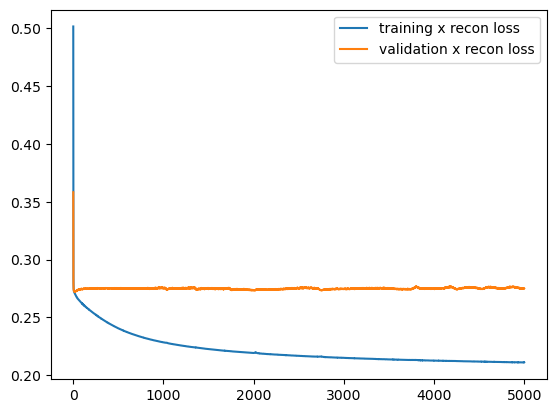

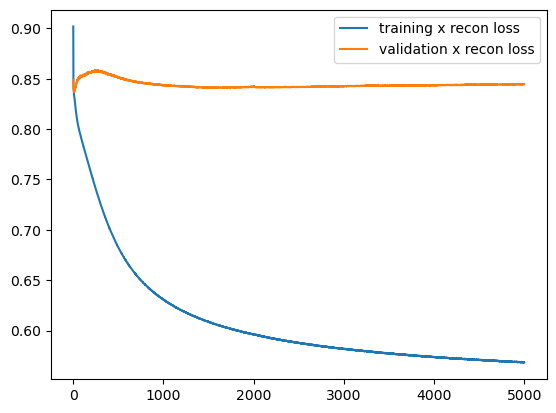

In [8]:
epochs=5000
plt.plot(np.arange(epochs),train_loss_rna_shared)
plt.plot(np.arange(epochs),val_loss_rna_shared)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_rnaShared'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'.jpg'))
plt.show()



plt.plot(np.arange(epochs),train_loss_atac_shared)
plt.plot(np.arange(epochs),val_loss_atac_shared)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_atacShared'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'.jpg'))
plt.show()